In [145]:
# True para "shut down" los graficos
graph_off = False

# True para "see all" gráficos
graph_on = True

# when graph_on == False :> True to check conclutions
graph_only_relevant = True

In [146]:
visualizar = not graph_off and (graph_on or graph_only_relevant)
visualizar_extra = not graph_off and graph_on

# WORKSHOP 3

**GRUPO 1: Barbot, Stigliano, Dupont**

***DIGITAL HOUSE: Abril 2022***

*Dataset: properatti.csv*


## Temas: ANALISIS EXPLORATORIO, CATEGORIZACION, MACHINE LEARNING

=============================================================================================================================



## 1) ANÁLISIS PRELIMINAR - [after cell 7]

   *Partiendo de la base que el dataset ya nos resultaba familiar, y considerando que ibamos a hacer un análisis sobre una muestra que no involucraba la predicción de la columna "price", es que arrancamos el desarrollo de este trabajo práctico utilizando 2 notebooks, las que denominamos **"backend"** y **"frontend"**. El origen de ésta notebook en particular, es una continuación de la de "frontend".* 
    
   *Desde el comienzo apuntamos a quedarnos con registros que sean con **"lat", "lon", y "rooms" no nulos**, ya que, considerabamos "rooms" como una variable de interés de estudio. Además acotamos los "state_name" a las features que se utilizaron en "workshop2_ml.ipynb", al comienzo incluso se excluyó de la condición de tener valores de "lat" y "lon" nulos, siempre que pertenezcan al mismo "place_name" de la respectiva notebook.*
    
   ***Gran parte de la limpieza de outliers fue de forma puntual a medida que se fueron presentando dentro de la visualización. Y gran parte sinó prácticamente toda la visualización que justifican aquellas celda fueron omitidas.***
    
   ***Es importante aclarar que para el estudio de la variable "rooms", se lo limitó a 4 habitaciones.***
    
**PREPROCESAMIENTO**
            
            - Abrir dataset, aplicar máscaras
            - Filtrar valores data.lat = Nan (en zonas de interés)
            - Filtrar solo "apartments"
            - Filtrar rooms notna()
            - Limpiar muestra de estudio
            - Establecer un límite superior en rooms de 4
            

## 2) CATEGORIAS MANUALES - [cell after 12]

**CONJUNTO 1: "etiqueta_final"**

    1: chico_caro
    2: chico_superior
    3: chico_medio
    4: chico_inferior
    5: grande_caro
    6: grande_barato
    
**MODELO 1: KNN**

    KNN: para separar chico_caro del resto
    KNN: para identificar cada categoría del conjunto 1
        
**CONJUNTO 2: "patron_geografico"**

    1: zona_centro
    2: zona_costa
    3: zona_periferica

**CONCLUSIONES 1**
    
## 3) CATEGORIAS MACHINE LEARNING - [after cell 84]

**CONJUNTO 3: "categoria_dbscan"**

   ***Regla del codo:***
   
        11 categorias
        60 outliers

**CONJUNTO 4: "categoria_jerarquica"**

   ***Coeficiente "Cophenetic":***
   
        4 categorias
        "average" score" = 0.87
    

## 4) CONCLUSIONES 2 - [after cell 101]

## 5) ANEXO - [after cell 102]

## 6) PROXIMAS ACTUALIZACIONES - [after cell 144]

In [147]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

In [148]:
import warnings

warnings.filterwarnings("ignore")

In [149]:
def data_info(data, name="data"):
    df = pd.DataFrame(pd.Series(data.columns))
    df.columns = ["columna"]
    df.columns.name = f"df de {name}"
    df.index.name = "index"
    df["Nan"] = data.isna().sum().values
    df["dtype"] = data.dtypes.values
    df["count"] = data.count().values
    df["pct_nan"] = round(df["Nan"] / data.shape[0] * 100, 2)
    df["count_unique"] = [
        len(data[elemento].value_counts()) for elemento in data.columns
    ]
    return df


def select_columns_in_list(data, n=7):
    features = [
        "state_name",
        "place_name",
        "lat",
        "lon",
        "price",
        "currency",
        "surface_total_in_m2",
        "surface_covered_in_m2",
        "rooms",
    ]
    return features + list(data.columns)[-n:]

In [150]:
sample_place_name = [
    "Palermo Soho",
    "Las Cañitas",
    "Balvanera",
    "Capital Federal",
    "Colegiales",
    "Floresta",
    "Barracas",
    "Recoleta",
    "Chacarita",
    "Palermo Hollywood",
    "Saavedra",
    "Villa Pueyrredón",
    "Coghlan",
    "Abasto",
    "Retiro",
    "San Nicolás",
    "Liniers",
    "Beccar",
    "Florida",
    "Adrogué",
    "Castelar",
    "Mataderos",
    "Palermo",
    "Flores",
    "Nuñez",
    "Barrio Norte",
    "Villa Crespo",
    "Paternal",
    "Villa Devoto",
    "Parque Patricios",
    "Once",
    "Parque Chacabuco",
    "Martínez",
    "San Isidro",
    "Acassuso",
    "Victoria",
    "San Miguel",
    "Barrio Los Alisos",
    "Banfield",
    "La Plata",
    "Wilde",
    "Canning",
    "Centro",
    "Plaza Mitre",
    "Güemes",
    "Caseros",
    "San Justo",
    "Villa Bosch",
    "Villa Luzuriaga",
    "Santos Lugares",
]

sample_state_name = [
    "Capital Federal",
    "Bs.As. G.B.A. Zona Norte",
    "Bs.As. G.B.A. Zona Sur",
    "Buenos Aires Costa Atlántica",
    "Bs.As. G.B.A. Zona Oeste",
]

In [151]:
data = pd.read_csv("properatti.csv")


# Convención de estructura de datos
Dicto = {}
Dicto["data_cruda"] = data.to_dict()
Dicto["data"] = [data.to_dict()]

# 1) <u>ANÁLISIS PRELIMINAR

### MÓDULO EXPLORATORIO

---
        Dataset: Properatti
        
  ***Mascaras aplicadas:***
        
        state_name: registros "lat" son no nulos, en zonas de particular interés.
        
        Place_name: son zonas de particular interés, pero que meten nan en "lat" dentro de la muestra. 
        
*El mapa mostrado contiene ejes coordenados ordenados, se diferencia la zona geográfica a la que se aboca este trabajo.*
*A modo de aclaración, se pierden muchos place_name de interés al desembocar el análisis en el descarte de 2 state_name completos.*
        
*Luego del tratamiento con los datos procedemos a unificar las dos muestras de trabajo.*

In [152]:
# AJUSTE DE TIPO DE CAMBIO, IMPLEMENTACION DE LA MASCARAS DE LAS ZONAS DE INTERES
data.loc[data.place_name.isna(), "place_name"] = "Tigre"
tc = np.mean(data.price_aprox_local_currency / data.price_aprox_usd)
mask_data = data.currency == "ARS"
data.loc[mask_data, "price"] = data[mask_data].price / tc
data.loc[mask_data, "currency"] = "USD"
mask_data = data.loc[:, "currency"] != "USD"
mask_data = data.loc[mask_data, "currency"].dropna().index
data.drop(mask_data, inplace=True)

mask_state = (data.state_name.isin(sample_state_name)) & data.lat.notna()
mask_place = data.place_name.isin(sample_place_name) & data.state_name.isin(
    sample_state_name
)
mask_place_view = (
    (data.place_name.isin(sample_place_name))
    & data.lat.notna()
    & data.state_name.isin(sample_state_name)
)

lista_mascara = [mask_state, mask_place_view]

data.drop(
    data[data.state_name == "Buenos Aires Costa Atlántica"].index, axis=0, inplace=True
)

for i in range(14):
    data.drop(data[mask_state].lon.idxmin(), inplace=True)

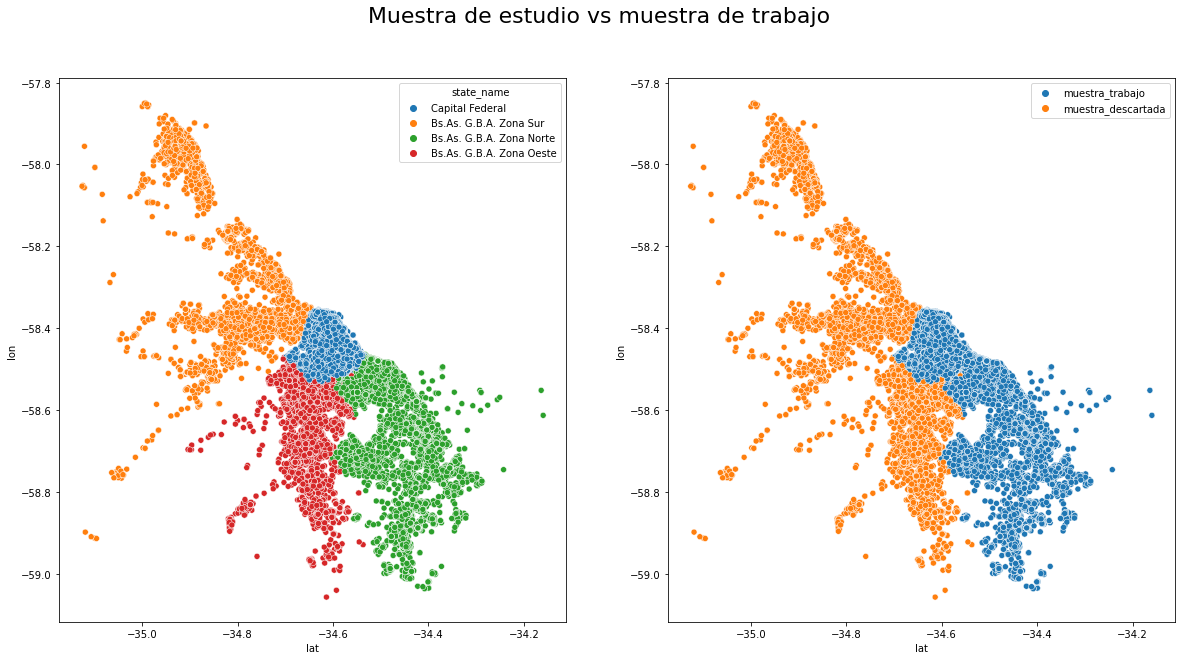

In [153]:
if visualizar:
    lista_trabajo = ["Capital Federal", "Bs.As. G.B.A. Zona Norte"]
    data.loc[
        data.state_name.isin(lista_trabajo), "etiqueta_trabajo"
    ] = "muestra_trabajo"
    data.etiqueta_trabajo.fillna("muestra_descartada", inplace=True)
    fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
    fig.suptitle("Muestra de estudio vs muestra de trabajo", size=22)
    sns.scatterplot(data=data[mask_state], x="lat", y="lon", ax=ax[0], hue="state_name")
    sns.scatterplot(
        data=data[mask_state], x="lat", y="lon", ax=ax[1], hue="etiqueta_trabajo"
    )
    data.drop("etiqueta_trabajo", axis=1, inplace=True)
    plt.legend();

### PREPROCESAMIENTO

In [154]:
# Incorporamos los valores que son| data.lat = Nan | en la muestra de sample_state
Dicto["sample_state"] = data[mask_state].to_dict()
Dicto["sample_place_linreg"] = data[mask_place].to_dict()
lista_indices_extraccion = list(pd.DataFrame(Dicto["sample_place_linreg"]).index)
lista_indices_muestra = list(pd.DataFrame(Dicto["sample_state"]).index)
diferencia_indices_1 = set(lista_indices_extraccion).difference(
    set(lista_indices_muestra)
)
diferencia_indices_1 = list(diferencia_indices_1)
data = pd.concat([data[mask_state], data.loc[diferencia_indices_1]], axis=0)

In [155]:
# Filtramos solo los departamentos

Dicto["data"].append(data.to_dict())
data = data.loc[data.property_type == "apartment"]
mask = data.rooms.notna()

Dicto["all_property"] = data.to_dict()
Dicto["apartment_only"] = data[mask].to_dict()

In [156]:
print(
    "Cantidad porcentual de rooms,\n{}\n\n\tObservacion:\n\t\t** Se procede a remover los que tengan mas de 4 rooms".format(
        pd.Series(data.rooms.value_counts(normalize=True)).to_string()
    )
)

data = data[data.eval("rooms <= 4")]

Cantidad porcentual de rooms,
2.0     0.315026
3.0     0.266891
1.0     0.214922
4.0     0.142746
5.0     0.040104
6.0     0.010777
7.0     0.005233
8.0     0.001969
9.0     0.000777
10.0    0.000518
12.0    0.000415
11.0    0.000207
17.0    0.000155
22.0    0.000104
15.0    0.000052
32.0    0.000052
14.0    0.000052

	Observacion:
		** Se procede a remover los que tengan mas de 4 rooms


-----------

# 2) CATEGORIAS MANUALES


## CONJUNTO 1: "etiqueta_final"

### 1: chico_caro

CATEGORIZACION 1: chico_caro/muestra_trabajo

CATEGORIZACION 2: chico/grande

LIMPIEZA E INSPECCIÓN DE ZONA DE INTERES PARA SELECCION DE UMBRAL

UMBRAL

ANÁLISIS ESTADÍSTICO DESCRIPTIVO, Y VISUALIZACIÓN

CATEGORIZACIÓN Y MACHINE LEARNING

### 5: grande_caro, 6: grande_barato

EXPLORACIÓN DE LA SECCIONES PARCIALES

PARTE 2: superior/medio/inferior

### 2: chico_superior, 3: chico_medio,  4: chico_inferior


### UNIFICACION DE LAS CATEGORIAS     
        
VISUALIZACIÓN E IDENTIFICACIÓN DE PATRONES

## MACHINE LEARNING 1

TRATAMIENTO DE LOS DATOS

KNN 1: Modelo para detectar caro/muestra_trabajo

KNN 2: Modelo para detectar todas las categorías del CONJUNTO 1

In [157]:
# Creación de columna dummy
data.loc[:, "_1_rooms"] = np.array(data.eval("rooms < 4")).astype(int)
data.loc[:, "_2_rooms"] = np.array(data.eval("rooms > 3")).astype(int)

# Creación de columna hue
labels = ["hasta 3 rooms", "4 rooms"]
bins = [0, 3.1, 4.1]
data.loc[:, "etiqueta_rooms"] = pd.cut(data.rooms, bins=bins, labels=labels)

Dicto["labels[]"] = [{"rooms": labels}]

In [158]:
# Limpieza auxiliar
# quitar valores outliers
data.drop(data.price.idxmax(), inplace=True)
for i in range(4):
    data.drop(data.surface_total_in_m2.idxmax(), inplace=True)
for i in range(3):
    data.drop(
        data[data.etiqueta_rooms == labels[0]].surface_total_in_m2.idxmax(),
        inplace=True,
    )

# definir cota superior
data.drop(data[data.price > 0.8 * 1e7].index, inplace=True)

### 1 : chico_caro

-------
                                                    CATEGORIZACION 1
                                                    
--------                                                    

In [159]:
categoria_caro = pd.DataFrame()
categoria_caro["hue_1"] = data.eval("surface_total_in_m2 < 45 and price > 0.50*1e6")
categoria_caro["hue_2"] = data.eval(
    "surface_total_in_m2 < 75 and surface_total_in_m2 >= 45 and price > 0.71*1e6"
)
categoria_caro["hue_3"] = data.eval(
    "surface_total_in_m2 < 100 and surface_total_in_m2 >= 75 and price > 0.8*1e6"
)
categoria_caro["hue_4"] = data.eval(
    "surface_total_in_m2 < 150 and surface_total_in_m2 >= 100 and price > 1.5*1e6"
)
categoria_caro["hue_5"] = data.eval(
    "surface_total_in_m2 < 200 and surface_total_in_m2 >= 150 and price > 3*1e6"
)
categoria_caro["hue_6"] = data.eval(
    "surface_total_in_m2 < 230 and surface_total_in_m2 >= 200 and price > 4*1e6"
)
categoria_caro["hue_all"] = categoria_caro.apply(lambda x: x.sum(), axis=1)

data.loc[:, "cat_price"] = categoria_caro["hue_all"]
data["etiqueta_price"] = data.cat_price.apply(
    lambda x: "chico_caro" if x == 1 else "muestra_estudio"
)
data.etiqueta_price.value_counts()

muestra_estudio    17993
chico_caro           133
Name: etiqueta_price, dtype: int64

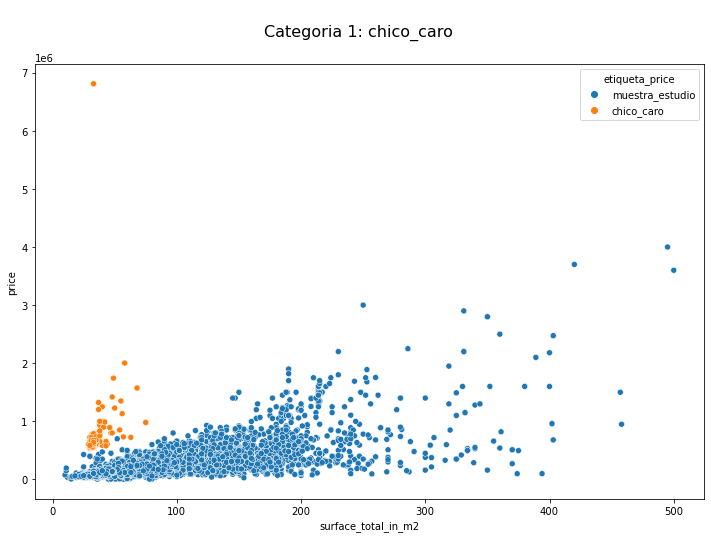

In [160]:
if visualizar_extra:
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.suptitle("\nCategoria 1: chico_caro", size=16)
    sns.scatterplot(x="surface_total_in_m2", y="price", data=data, hue="etiqueta_price")

In [161]:
# limpieza de outliers
data.drop(data.surface_total_in_m2.idxmax(), inplace=True)
data.drop(data.price.idxmax(), inplace=True)
data.drop(data.surface_total_in_m2.idxmax(), inplace=True)

In [162]:
lista = list(data.state_name.unique())
Dicto["caro"] = data.drop(data[data.state_name.isin(lista[-2:])].index)[
    data.cat_price == 1
].to_dict()
Dicto["barato"] = data[data.cat_price == 0].to_dict()

-----------
                                            CATEGORIZACION 2: Chico/Grande (Parcial)

-------

In [163]:
data = pd.DataFrame(Dicto["barato"])

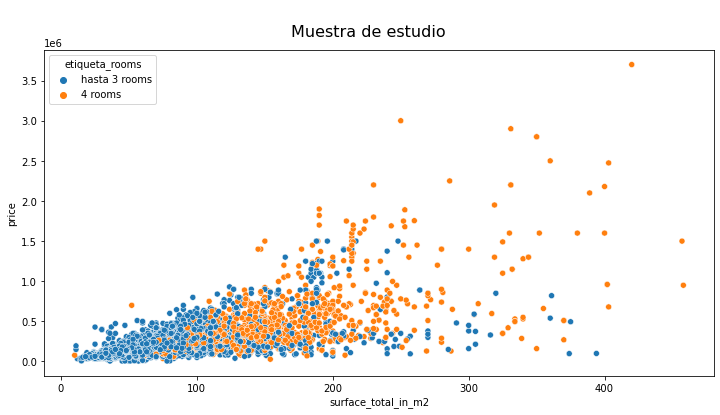

In [164]:
if visualizar_extra:
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.suptitle("\nMuestra de estudio", size=16)
    sns.scatterplot(x="surface_total_in_m2", y="price", data=data, hue="etiqueta_rooms")

------
                                LIMPIEZA E INSPECCIÓN DE ZONA DE INTERES PARA SELECCION DE UMBRAL
                                                
------

In [165]:
Dicto["limpieza_1"] = [data.to_dict()]

for i in range(5):
    data.drop(
        data[data.etiqueta_rooms == labels[1]].surface_total_in_m2.idxmin(),
        inplace=True,
    )

mask = data.surface_total_in_m2 < 100
for i in range(4):
    data.drop(
        data.loc[mask, "price"].loc[data.etiqueta_rooms == labels[1]].idxmax(),
        inplace=True,
    )

mask = data.surface_total_in_m2 < 150
for i in range(4):
    data.drop(
        data.loc[mask, "price"].loc[data.etiqueta_rooms == labels[1]].idxmax(),
        inplace=True,
    )

mask = data.cat_price == 0
data.drop(
    data.loc[mask, "price"]
    .loc[
        data.eval(
            "surface_total_in_m2 < 300 and surface_total_in_m2 > 200 and price > 2.6*1e6"
        )
    ]
    .index,
    inplace=True,
)
data.drop(
    data[
        data.eval("surface_total_in_m2 < 400 and surface_total_in_m2 > 300")
    ].price.idxmax(),
    inplace=True,
)

Dicto["limpieza_1"].append(data.to_dict())

In [166]:
labels

['hasta 3 rooms', '4 rooms']

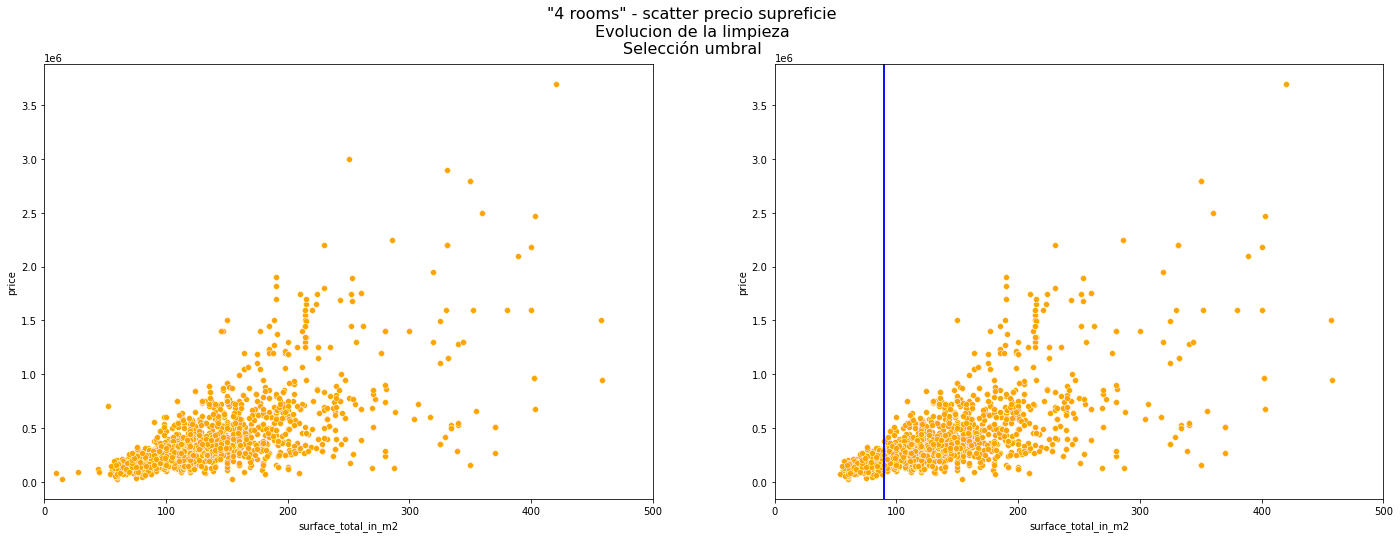

In [167]:
if visualizar_extra:
    fig, ax = plt.subplots(ncols=2, figsize=(24, 8))
    fig.suptitle(
        f'"{labels[1]}" - scatter precio supreficie\nEvolucion de la limpieza\nSelección umbral',
        size=16,
    )

    for i in range(2):
        dataview = pd.DataFrame(Dicto["limpieza_1"][i])
        ax[i].set(xlim=(0, 500))
        plt.axvline(x=90, **{"color": "b"})
        sns.scatterplot(
            x="surface_total_in_m2",
            y="price",
            data=dataview[dataview.etiqueta_rooms == labels[1]],
            color="orange",
            ax=ax[i],
        )

In [168]:
data.drop(
    data[data.etiqueta_rooms == "hasta 3 rooms"]
    .loc[data.rooms == 3, "surface_total_in_m2"]
    .idxmin(),
    inplace=True,
)
data.drop(
    data[data.etiqueta_rooms == "hasta 3 rooms"]
    .loc[data.rooms == 2, "surface_total_in_m2"]
    .idxmin(),
    inplace=True,
)

    En conclusión, la línea azul es un buen punto para trazar el umbral, debido a que luego de atravesarla la dispersión de datos aumenta su varianza.

In [169]:
features = [
    "state_name",
    "place_name",
    "lat",
    "lon",
    "price",
    "currency",
    "surface_total_in_m2",
    "surface_covered_in_m2",
    "rooms",
    "etiqueta_rooms",
    "_1_rooms",
    "_2_rooms",
    "cat_price",
]
# drop de valores: para cada state_name, eliminar los lat y los lon que hacen que el gráfico se vea tan extendido
categoria_state_name = pd.DataFrame(index=data.index)
lista = data.state_name.unique()
i = 3  # zona sur

bins = [-np.inf, -35, -34.65, np.inf]
labels = [False, True, False]
categoria_state_name["etiqueta_zona_sur_lat"] = pd.cut(
    data[data.state_name == lista[i]].lat, bins=bins, labels=labels, ordered=False
)

bins = [-np.inf, -58.6, np.inf]
labels = [False, True]
categoria_state_name["etiqueta_zona_sur_lon"] = pd.cut(
    data[data.state_name == lista[i]].lon, bins=bins, labels=labels
)

i = 0
bins = [-np.inf, -34.367, np.inf]
labels = [True, False]
categoria_state_name["etiqueta_zona_norte_lat"] = pd.cut(
    data[data.state_name == lista[i]].lat, bins=bins, labels=labels
)
categoria_state_name[
    "etiqueta_zona_norte_lon"
] = True  # dividir el gráfico en dos sobre esta coordenada

i = 1
categoria_state_name["etiqueta_cap_fed_lat"] = True
categoria_state_name["etiqueta_cap_fed_lon"] = True

i = 2
bins = [-np.inf, -34.71, np.inf]
labels = [False, True]
categoria_state_name["etiqueta_zona_oeste_lat"] = pd.cut(
    data[data.state_name == lista[i]].lat, bins=bins, labels=labels
)

bins = [-np.inf, -58.9, np.inf]
labels = [False, True]
categoria_state_name["etiqueta_zona_oeste_lon"] = pd.cut(
    data[data.state_name == lista[i]].lat, bins=bins, labels=labels
)

categoria_state_name["hue_all"] = categoria_state_name.fillna(True).all(axis=1)
# print('Cantidad de elementos "False" que caen dentro de la categoría drop\n{}'.format(categoria_state_name.hue_all.value_counts()))#check
data.drop(
    categoria_state_name[categoria_state_name.hue_all == False].index, inplace=True
)

labels = list(Dicto["labels[]"][0].values())[0]
lista_drop = list(
    data.loc[data.state_name == lista[1]]
    .loc[data.etiqueta_rooms == labels[0], features]
    .sort_values(by="surface_total_in_m2", ascending=False)
    .index
)[:2]
data.drop(lista_drop, inplace=True)
data.drop(
    data[data.eval("_1_rooms == 1 and surface_total_in_m2 > 305")].index, inplace=True
)

In [170]:
lista = list(data.state_name.unique())
data.drop(data[data.state_name.isin(lista[-2:])].index, inplace=True)
data.drop(
    data.sort_values(by="surface_total_in_m2", ascending=False).head(8).index,
    inplace=True,
)
data.drop(data[data.state_name == lista[0]].price.idxmax(), inplace=True)
data.drop(data[data.price > 2.85 * 1e6].index, inplace=True)

------------------------
                                                    UMBRAL
                                                
-------------------------                                                

**UMBRAL CATEGORÍA 2**

tranquilamente podría ir en la celda 1

In [171]:
umbral = 90.1
Dicto["umbral"] = umbral

data["_3_surface"] = np.array(data.eval("surface_total_in_m2 <= 90").values).astype(int)
data["_4_surface"] = np.array(data.eval("surface_total_in_m2 > 90").values).astype(int)

bins = [-np.inf, umbral, np.inf]
labels = ["chico", "grande"]
data["cat_surface"] = pd.cut(data.surface_total_in_m2, bins=bins, labels=labels)

Dicto["labels[]"].append({"cat_surface": labels})

In [172]:
Dicto["barato_chico"] = data[data["_3_surface"] == 1].to_dict()
Dicto["barato_grande"] = data[data["_4_surface"] == 1].to_dict()

--------------------
                                ANÁLISIS ESTADÍSTICO DESCRIPTIVO Y VISUALIZACIÓN
                                                    
------------------------

In [173]:
print("Los valores de media y varianza de los state_name de trabajo son:\n\nMedia:")
print(
    "{}\nDev:".format(data.groupby("state_name")["price"].mean().round(2).to_string())
)
print("{}\nCV:".format(data.groupby("state_name")["price"].std().round(2).to_string()))
print(
    "{}".format(
        (
            data.groupby("state_name")["price"].std()
            / data.groupby("state_name")["price"].mean()
        )
        .round(2)
        .to_string()
    )
)

Los valores de media y varianza de los state_name de trabajo son:

Media:
state_name
Bs.As. G.B.A. Zona Norte    191918.67
Capital Federal             198808.13
Dev:
state_name
Bs.As. G.B.A. Zona Norte    130310.99
Capital Federal             203463.25
CV:
state_name
Bs.As. G.B.A. Zona Norte    0.68
Capital Federal             1.02


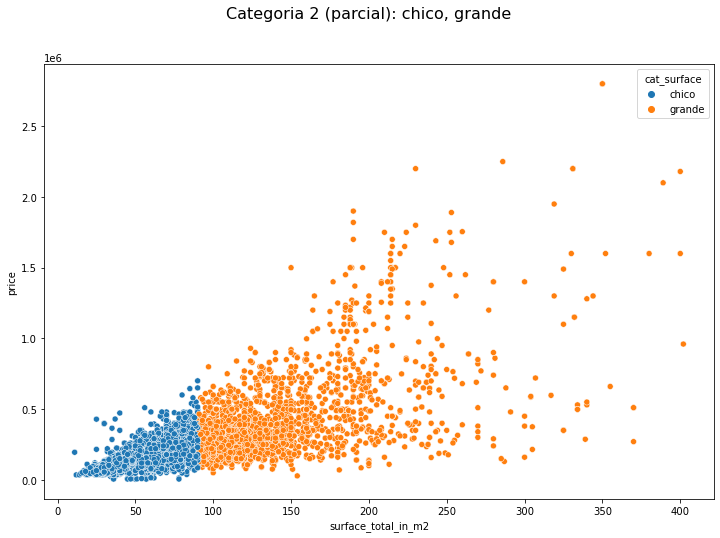

In [174]:
if visualizar_extra:
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.suptitle("Categoria 2 (parcial): chico, grande", size=16)
    sns.scatterplot(x="surface_total_in_m2", y="price", data=data, hue="cat_surface")

In [175]:
# Obtenemos muestra de superficies nulas para posterior tratamiento

index_muestra = list(data[data.surface_total_in_m2.isna()].index) + list(
    data[data.surface_covered_in_m2.isna()].index
)

Dicto["muestra_surface_nan"] = data.loc[index_muestra].to_dict()

data.drop(index_muestra, inplace=True)
data.drop(data[data.price.isna()].index, inplace=True)

--------------
                                    CATEGORIZACION Y MACHINE LEARNING

--------

### 5 : grande_caro, 6: grande_barato                               

In [176]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

features_1 = ["surface_total_in_m2", "_3_surface"]

X = data[features_1]
y = data.price

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=X._3_surface)

model_1 = linreg.fit(X_train, y_train)

In [177]:
data["y_eval"] = model_1.predict(data[features_1])
data["_5_price"] = np.array(data.eval("price > y_eval")).astype(int)
data["_6_price"] = np.array(data.eval("price <= y_eval")).astype(int)
data.drop("y_eval", axis=1, inplace=True)

bins = [-0.1, 0.5, 1.1]
labels = ["grande_barato", "grande_caro"]
data["cat_price_2"] = pd.cut(data._5_price, bins=bins, labels=labels)

Dicto["labels[]"].append({"price": labels})

In [178]:
data[["_5_price", "_6_price"]].value_counts()

_5_price  _6_price
0         1           5562
1         0           4684
dtype: int64

In [179]:
categoria_view = pd.DataFrame()

categoria_view["hue_1"] = data.eval('cat_surface == "chico"')
categoria_view["hue_2"] = data.eval(
    'cat_surface == "grande" and cat_price_2 == "grande_caro"'
)
categoria_view["hue_3"] = data.eval(
    'cat_surface == "grande" and cat_price_2 == "grande_barato"'
)

categoria_view.loc[categoria_view.hue_1, "orden_1"] = "chico"
categoria_view.loc[categoria_view.hue_2, "orden_2"] = "grande_caro"
categoria_view.loc[categoria_view.hue_3, "orden_3"] = "grande_barato"

categoria_view.orden_1.fillna(categoria_view.orden_2, inplace=True)
categoria_view.orden_1.fillna(categoria_view.orden_3, inplace=True)

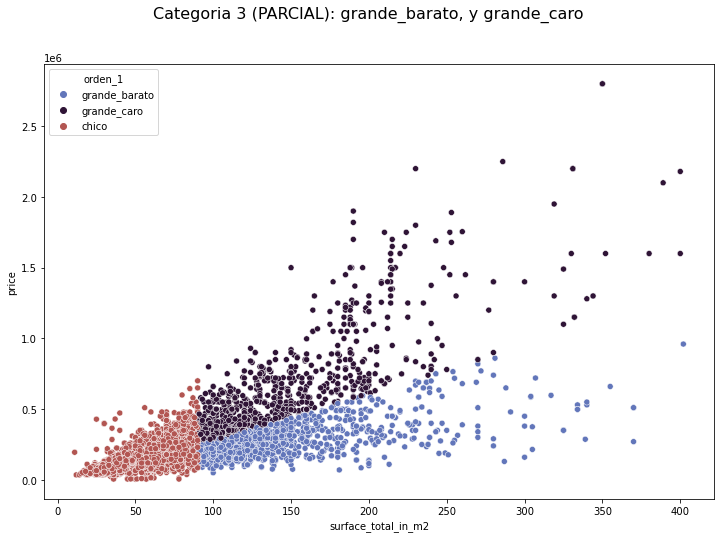

In [180]:
if visualizar_extra:
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.suptitle("Categoria 3 (PARCIAL): grande_barato, y grande_caro", size=16)
    sns.scatterplot(
        x="surface_total_in_m2",
        y="price",
        data=data,
        hue=categoria_view.orden_1,
        palette="twilight",
    )

----------------------------------
                                    EXPLORACIÓN DE LA SECCIONES PARCIALES
                                    
---------------------------------                                    

In [181]:
Dicto["grande_barato"] = data[data._5_price == 1].to_dict()
Dicto["grande_caro"] = data[data._6_price == 1].to_dict()
Dicto["data"].append(data.to_dict())

In [182]:
print('Cantidad porcentual de rooms en seccion "{}"'.format(labels[1]))
display(
    data.loc[
        (data.cat_price_2 == "grande_caro") & (data.cat_surface == "grande")
    ].rooms.value_counts(normalize=True)
)

Cantidad porcentual de rooms en seccion "grande_caro"


4.0    0.549439
3.0    0.409786
2.0    0.038736
1.0    0.002039
Name: rooms, dtype: float64

-------
                                    PARTE 2: superior/medio/inferior

---

In [183]:
mask = data.cat_surface == "chico"

model_2 = LinearRegression()

X = data[mask].surface_total_in_m2
y = data[mask].price

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train = np.array(X_train).reshape(-1, 1)
y_train = np.array(y_train)

model_2.fit(X_train, y_train)

#####

X = np.array(X).reshape(-1, 1)

array_predict = model_2.predict(X)

mask_std = (
    pd.Series(array_predict).describe().index == "std"
)  ## <------------------ se toma mascara del dataframe.describe()

#####


def recta_original(data, label, model):

    test_raw = np.array(data[label].values)
    coeficientes = model.coef_

    resultado = []
    for i in range(len(test_raw)):
        termino = []
        suma = model.intercept_
        for j in range(len(coeficientes)):
            termino.append(coeficientes[j] * test_raw[i])
        for j in range(len(termino)):
            suma += termino[j]
        resultado.append(suma)
    return np.array(resultado)


data.loc[mask, "recta_1"] = recta_original(data[mask], "surface_total_in_m2", model_2)
serie_recta = data.loc[mask, ["recta_1"]]
serie_recta.index = (data.loc[mask, "surface_total_in_m2"].values.reshape(1, -1))[0]
serie_recta = serie_recta.iloc[:, 0]
data.drop("recta_1", axis=1, inplace=True)

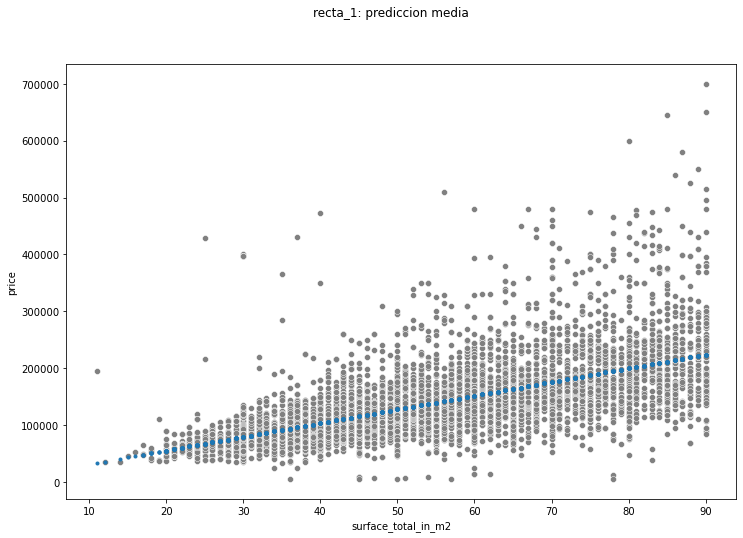

In [184]:
if visualizar_extra:
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.suptitle("recta_1: prediccion media")
    sns.scatterplot(
        data=data[mask], x="surface_total_in_m2", y="price", color="gray"
    ),  # hue=np.array(data[mask].surface_total_in_m2 > recta_1).astype(int))
    plt.plot(serie_recta, ".");

In [185]:
def rectas_2_3_predict(recta_1, array_predict, n_dev=0.73314):
    mask_std = pd.Series(array_predict).describe().index == "std"
    deviation = pd.Series(array_predict).describe()[mask_std].values

    factor = n_dev
    recta_2 = recta_1 + factor * deviation
    recta_3 = recta_1 - factor * deviation

    return recta_2, recta_3


##### MODIFICAR EL PARAMETRO n_dev, para elegir las distancias entre las rectas
recta_2, recta_3 = rectas_2_3_predict(serie_recta, array_predict)

serie_recta_2 = pd.Series(recta_2, index=serie_recta.index)
serie_recta_3 = pd.Series(recta_3, index=serie_recta.index)

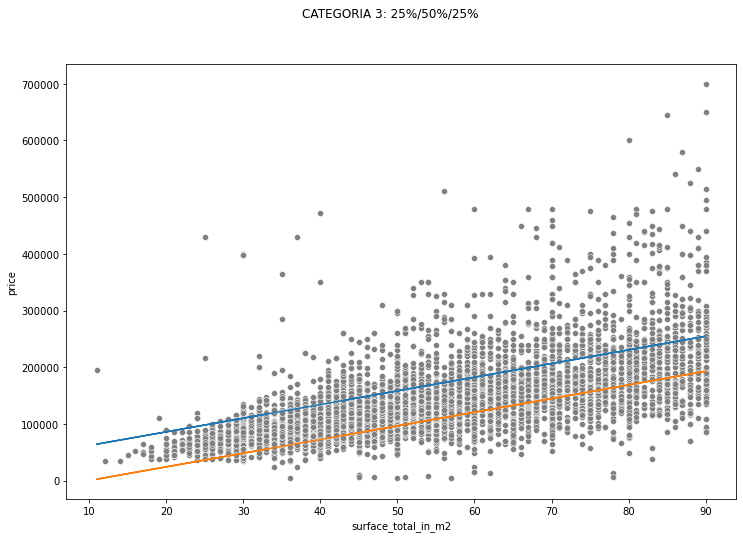

In [186]:
if visualizar_extra:
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.suptitle("CATEGORIA 3: 25%/50%/25%")
    sns.scatterplot(data=data[mask], x="surface_total_in_m2", y="price", color="gray")
    ax.plot(serie_recta_2)
    ax.plot(serie_recta_3)

In [187]:
data.loc[mask, "recta_2"] = serie_recta_2.values
data.loc[mask, "recta_3"] = serie_recta_3.values
data.loc[mask, "_7_surface"] = np.array(data[mask].eval("price > recta_2")).astype(int)
data.loc[mask, "_8_surface"] = np.array(
    data[mask].eval("price <= recta_2 and price > recta_3")
).astype(int)
data.loc[mask, "_9_surface"] = np.array(data[mask].eval("price <= recta_3")).astype(int)
data.drop(["recta_2", "recta_3"], axis=1, inplace=True)

data;

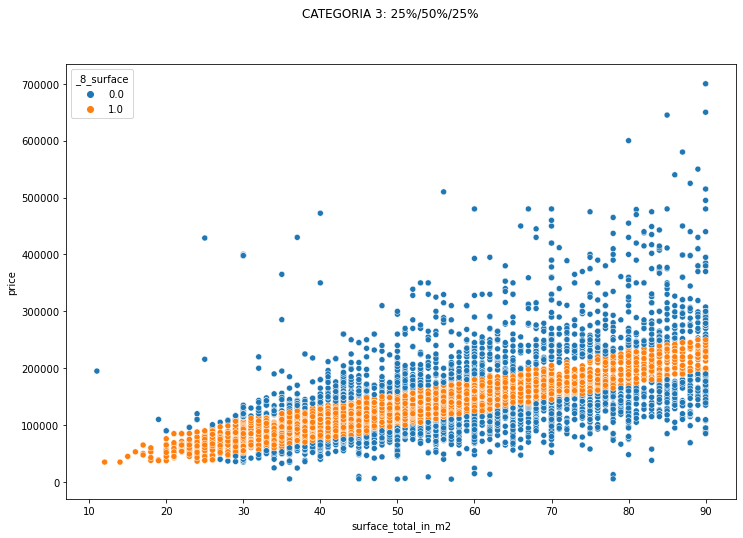

In [188]:
if visualizar_extra:
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.suptitle("CATEGORIA 3: 25%/50%/25%")
    sns.scatterplot(
        data=data[mask], x="surface_total_in_m2", y="price", hue="_8_surface"
    )

### 2: chico_superior, 3: chico_medio, 4: chico_inferior

In [189]:
categoria_chico = pd.DataFrame(index=data[mask].index)
mask_1 = data._9_surface == 1
categoria_chico.loc[mask_1, "hue_1"] = "chico_inferior"
mask_1 = data._8_surface == 1
categoria_chico.loc[mask_1, "hue_2"] = "chico_medio"
mask_1 = data._7_surface == 1
categoria_chico.loc[mask_1, "hue_3"] = "chico_superior"

categoria_chico["hue_1"].fillna(categoria_chico["hue_2"], inplace=True)
categoria_chico["hue_1"].fillna(categoria_chico["hue_3"], inplace=True)

data.loc[mask, "etiqueta_final"] = categoria_chico["hue_1"]
data["etiqueta_final"].fillna(data.cat_price_2, inplace=True)
data;

### UNIFICACIÓN DE CATEGORÍAS

In [190]:
data = pd.concat([data, pd.DataFrame(Dicto["caro"])], axis=0)

data["etiqueta_final"].fillna(data.etiqueta_price, inplace=True)

data.loc[:, ["_3_surface", "_4_surface"]].fillna(0, inplace=True)
data.loc[:, ["_5_price", "_6_price"]].fillna(0, inplace=True)
data.loc[:, ["_7_surface", "_8_surface", "_9_surface"]].fillna(
    0, inplace=True
)  # (!) consulta: porque? no consigo que se eliminen todos los nans de estas columnas

In [191]:
categoria_final = pd.DataFrame(index=data.index)

categoria_final["hue_1"] = data.eval('etiqueta_final == "chico_caro"')
categoria_final["hue_2"] = data.eval('etiqueta_final == "chico_superior"')
categoria_final["hue_3"] = data.eval('etiqueta_final == "chico_medio"')
categoria_final["hue_4"] = data.eval('etiqueta_final == "chico_inferior"')
categoria_final["hue_5"] = data.eval('etiqueta_final == "grande_caro"')
categoria_final["hue_6"] = data.eval('etiqueta_final == "grande_barato"')

categoria_final.loc[categoria_final["hue_1"] == True, "orden_1"] = 1
categoria_final.loc[categoria_final["hue_2"] == True, "orden_2"] = 2
categoria_final.loc[categoria_final["hue_3"] == True, "orden_3"] = 3
categoria_final.loc[categoria_final["hue_4"] == True, "orden_4"] = 4
categoria_final.loc[categoria_final["hue_5"] == True, "orden_5"] = 5
categoria_final.loc[categoria_final["hue_6"] == True, "orden_6"] = 6

categoria_final["orden_1"].fillna(categoria_final["orden_2"], inplace=True)
categoria_final["orden_1"].fillna(categoria_final["orden_3"], inplace=True)
categoria_final["orden_1"].fillna(categoria_final["orden_4"], inplace=True)
categoria_final["orden_1"].fillna(categoria_final["orden_5"], inplace=True)
categoria_final["orden_1"].fillna(categoria_final["orden_6"], inplace=True)

data.loc[:, "categoria_final"] = categoria_final["orden_1"]

---------------------
                VISUALIZACIÓN DE CATEGORÍAS E IDENTIFICACIÓN DE PATRONES

-------------------

- Identificación de etiquetas

- Identificación de patrones geograficos: CONJUNTO 2

In [192]:
dataview = pd.DataFrame(data[["surface_total_in_m2", "price"]], index=data.index)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

dataview = scaler.fit_transform(dataview)

dataview = pd.DataFrame(
    dataview, columns=["surface_total_in_m2", "price"], index=data.index
)

dataview.loc[:, "categoria_final"] = data.categoria_final

dataview = pd.concat([dataview, data[["lat", "lon"]]], axis=1)

dataview.columns.name = "data_standarized"

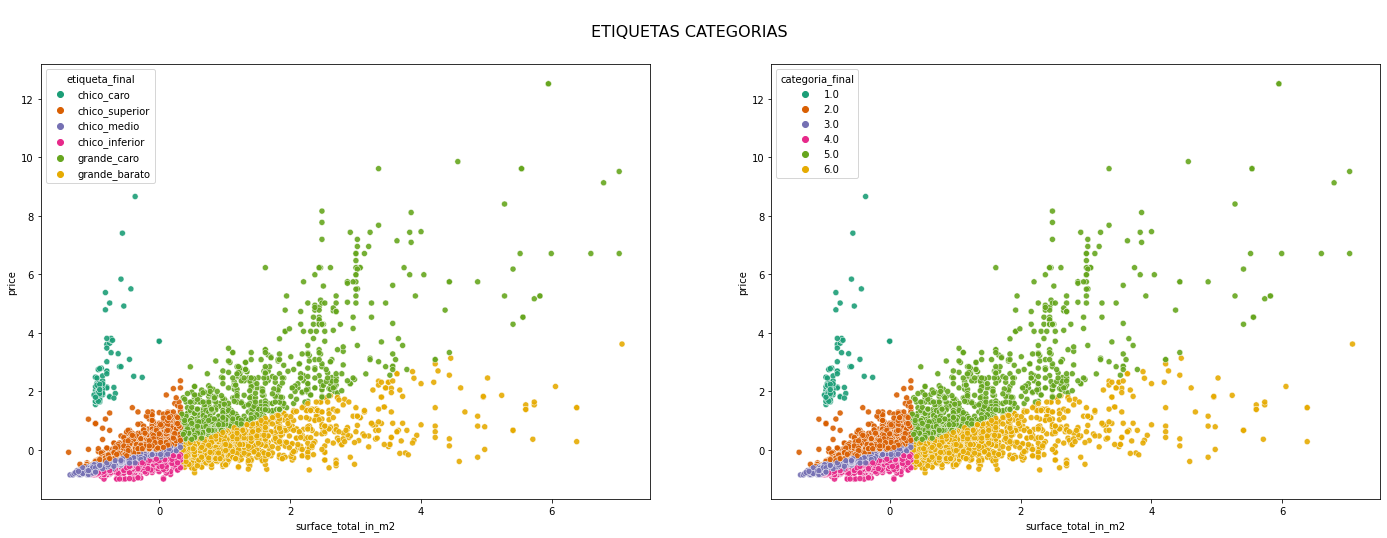

In [193]:
# identificacion de etiquetas
if visualizar:
    fig, ax = plt.subplots(ncols=2, figsize=(24, 8))
    fig.suptitle("\nETIQUETAS CATEGORIAS", size=16)

    hue_orden = [
        "chico_caro",
        "chico_superior",
        "chico_medio",
        "chico_inferior",
        "grande_caro",
        "grande_barato",
    ]
    sns.scatterplot(
        x="surface_total_in_m2",
        y="price",
        data=dataview,
        hue=data["etiqueta_final"],
        hue_order=hue_orden,
        alpha=0.9,
        palette="Dark2",
        ax=ax[0],
    )
    sns.scatterplot(
        x="surface_total_in_m2",
        y="price",
        data=dataview,
        hue=data["categoria_final"],
        alpha=0.9,
        palette="Dark2",
        ax=ax[1],
    )

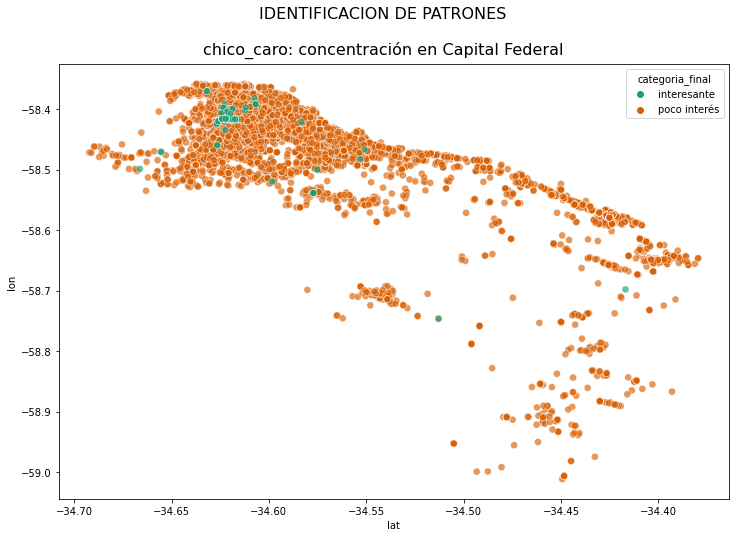

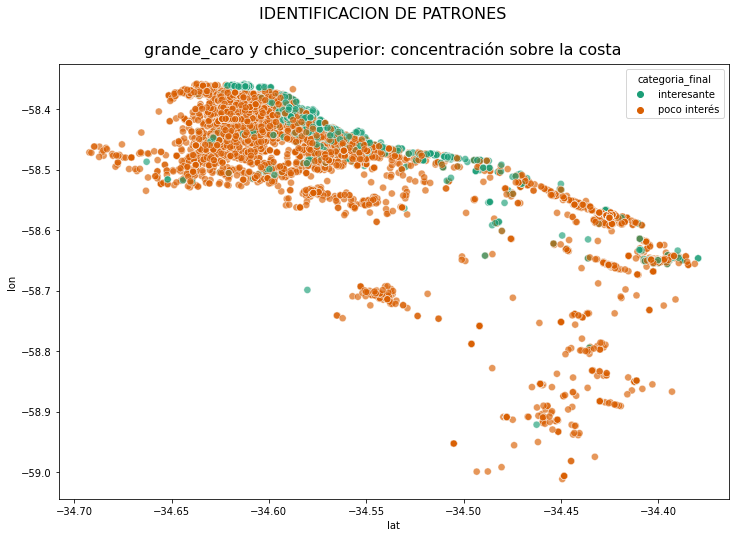

In [194]:
# identificacion de patrones geograficos: CONJUNTO 2

categoria = pd.cut(
    dataview.categoria_final,
    bins=[-0.1, 1.1, np.inf],
    labels=["interesante", "poco interés"],
    ordered=False,
)
if visualizar_extra:
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.suptitle(
        "IDENTIFICACION DE PATRONES\n\nchico_caro: concentración en Capital Federal",
        size=16,
    )
    sns.scatterplot(
        x="lat",
        y="lon",
        data=dataview,
        hue=categoria,
        s=50,
        alpha=0.65,
        palette="Dark2",
    )

categoria = pd.cut(
    dataview.categoria_final,
    bins=[-0.1, 1.1, 2.1, 4.1, 5.1, np.inf],
    labels=[
        "poco interés",
        "interesante",
        "poco interés",
        "interesante",
        "poco interés",
    ],
    ordered=False,
)
if visualizar_extra:
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.suptitle(
        "IDENTIFICACION DE PATRONES\n\ngrande_caro y chico_superior: concentración sobre la costa",
        size=16,
    )
    sns.scatterplot(
        x="lat",
        y="lon",
        data=dataview,
        hue=categoria,
        s=50,
        alpha=0.65,
        palette="Dark2",
    )

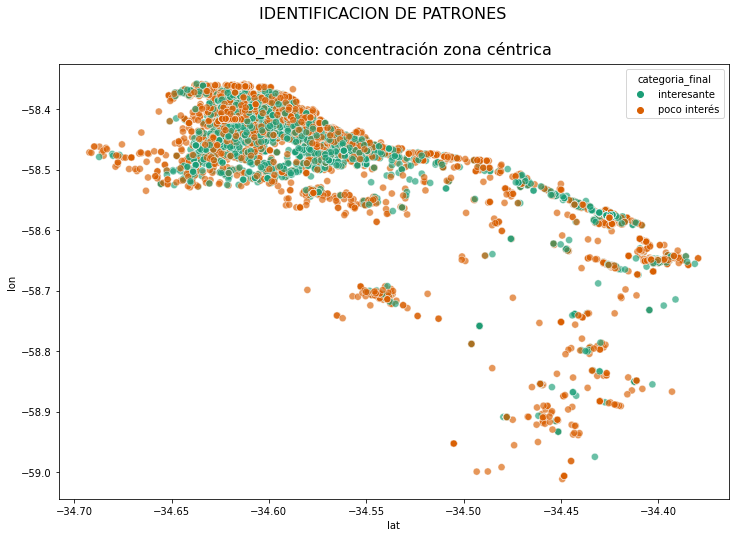

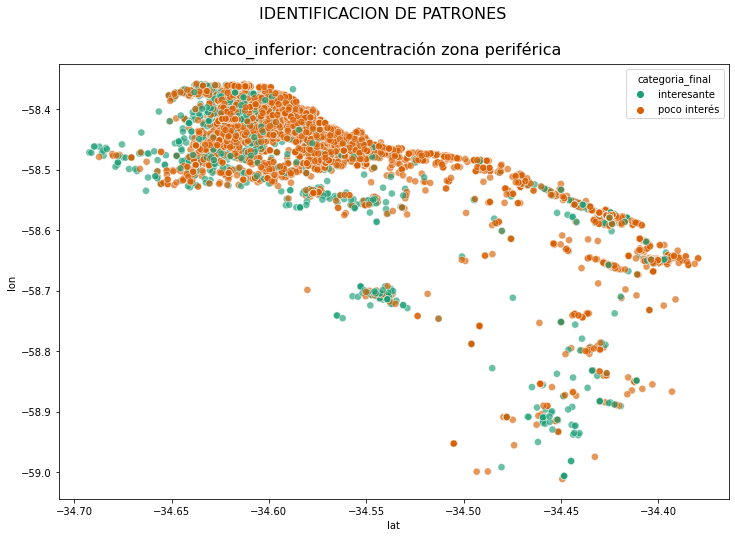

In [195]:
categoria = pd.cut(
    dataview.categoria_final,
    bins=[-0.1, 2.1, 3.1, np.inf],
    labels=["poco interés", "interesante", "poco interés"],
    ordered=False,
)
if visualizar_extra:
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.suptitle(
        "IDENTIFICACION DE PATRONES\n\nchico_medio: concentración zona céntrica",
        size=16,
    )
    sns.scatterplot(
        x="lat",
        y="lon",
        data=dataview,
        hue=categoria,
        s=50,
        alpha=0.65,
        palette="Dark2",
    )

categoria = pd.cut(
    dataview.categoria_final,
    bins=[-0.1, 3.1, 4.1, np.inf],
    labels=["poco interés", "interesante", "poco interés"],
    ordered=False,
)
if visualizar_extra:
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.suptitle(
        "IDENTIFICACION DE PATRONES\n\nchico_inferior: concentración zona periférica",
        size=16,
    )
    sns.scatterplot(
        x="lat",
        y="lon",
        data=dataview,
        hue=categoria,
        s=50,
        alpha=0.65,
        palette="Dark2",
    )

## MACHINE LEARNING 1

------------
                                    TRATAMIENTO DE LOS DATOS
                                    
------------------                                    

In [196]:
features = [
    "state_name",
    "place_name",
    "lat",
    "lon",
    "price",
    "currency",
    "surface_total_in_m2",
    "surface_covered_in_m2",
    "rooms",
    "expenses",
    "floor",
    "categoria_final",
    "etiqueta_final",
]

In [197]:
data_info(data[features])

df de data                columna   Nan    dtype  count  pct_nan  count_unique
index                                                                         
0                      state_name     0   object  10370     0.00             2
1                      place_name     0   object  10370     0.00           129
2                             lat   227  float64  10143     2.19          5615
3                             lon   227  float64  10143     2.19          5591
4                           price     0  float64  10370     0.00          2053
5                        currency     0   object  10370     0.00             1
6             surface_total_in_m2     0  float64  10370     0.00           272
7           surface_covered_in_m2     0  float64  10370     0.00           238
8                           rooms     0  float64  10370     0.00             4
9                        expenses  9001  float64   1369    86.80           238
10                          floor  9623  float64    747    92.80            20
11                categoria_final     0  float64  10370     0.00             6
12                 etiqueta_final     0   object  10370     0.00             6

In [198]:
Dicto["data"].append(data[features])
data[features].head()

state_name      place_name        lat        lon     price  \
17  Bs.As. G.B.A. Zona Norte  Barrio El Golf -34.408717 -58.634389  315000.0   
19           Capital Federal         Palermo -34.580504 -58.405874  350000.0   
21           Capital Federal         Palermo -34.590926 -58.411665  270500.0   
29           Capital Federal          Flores -34.635118 -58.473964   75000.0   
33  Bs.As. G.B.A. Zona Norte  Barrio El Golf -34.408717 -58.634389  325000.0   

   currency  surface_total_in_m2  surface_covered_in_m2  rooms  expenses  \
17      USD                176.0                   78.0    3.0       NaN   
19      USD                104.0                   96.0    3.0       NaN   
21      USD                118.0                   73.0    4.0       NaN   
29      USD                 43.0                   43.0    2.0       NaN   
33      USD                186.0                   83.0    3.0       NaN   

    floor  categoria_final  etiqueta_final  
17    NaN              6.0   grande_barato  
19    NaN              5.0     grande_caro  
21    NaN              6.0   grande_barato  
29    NaN              4.0  chico_inferior  
33    NaN              6.0   grande_barato

-----
                                                    KNN 1

---

In [199]:
# 1ro: KNN separamos 1, de (2,3,4), con grid search falta
# (3)

features_knn = ["surface_total_in_m2", "price"]
X = data[features_knn]
y = data.cat_price  # los 0 son baratos y los 1 son caros

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

# (4)
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(X, y, stratify=y, random_state=90)


# (1), (2)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold

k_fold = KFold(n_splits=5, shuffle=True, random_state=90)

lista_scores = []
for i in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=i)
    cross_val = cross_val_score(knn, X_train, y_train, cv=k_fold)
    dicc = {
        "cv_mean": np.mean(cross_val),
        "cv_std": np.std(cross_val),
        "n_neighbors": i,
    }
    lista_scores.append(dicc)

df_scores = pd.DataFrame(lista_scores)
best_score = df_scores.loc[df_scores["cv_mean"].idxmax(), "n_neighbors"]

knn_optimized = KNeighborsClassifier(n_neighbors=best_score)

# (5)

knn_fit = knn_optimized.fit(X_train, y_train)

# (6)

y_pred = knn_fit.predict(X_test)
array_predict = knn_fit.predict(scaler.fit_transform(data[features_knn]))

# (7)

from sklearn.metrics import accuracy_score

print("accuracy_test knn:\n{}".format(accuracy_score(y_pred, y_test).round(2)))

accuracy_test knn:
1.0


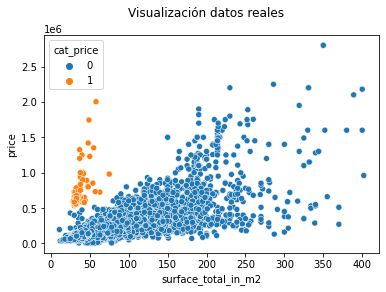

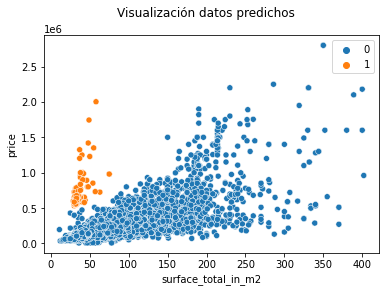

In [200]:
if visualizar:
    fig, ax = plt.subplots()
    fig.suptitle("Visualización datos reales")

    sns.scatterplot(data=data, x="surface_total_in_m2", y="price", hue="cat_price")

    fig, ax = plt.subplots()
    fig.suptitle("Visualización datos predichos")
    sns.scatterplot(data=data, x="surface_total_in_m2", y="price", hue=array_predict)

-----------
                                                KNN 2
                                                
------                                                

In [201]:
# 2do: KNN todas las categorías

features_knn = ["surface_total_in_m2", "price"]
X = data[features_knn]
y = data.categoria_final

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

# (4)
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(X, y, stratify=y, random_state=90)


# (1), (2)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold

k_fold = KFold(n_splits=5, shuffle=True, random_state=90)

lista_scores = []
for i in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=i)
    cross_val = cross_val_score(knn, X_train, y_train, cv=k_fold)
    dicc = {
        "cv_mean": np.mean(cross_val),
        "cv_std": np.std(cross_val),
        "n_neighbors": i,
    }
    lista_scores.append(dicc)

df_scores = pd.DataFrame(lista_scores)
best_score = df_scores.loc[df_scores["cv_mean"].idxmax(), "n_neighbors"]

knn_optimized = KNeighborsClassifier(n_neighbors=best_score)

# (5)

knn_fit = knn_optimized.fit(X_train, y_train)

# (6)

y_pred = knn_fit.predict(X_test)
predict_classes = knn_fit.predict(scaler.fit_transform(X))
# (7)

from sklearn.metrics import accuracy_score

print("accuracy_test knn:\n{}".format(accuracy_score(y_pred, y_test).round(3)))

accuracy_test knn:
0.989


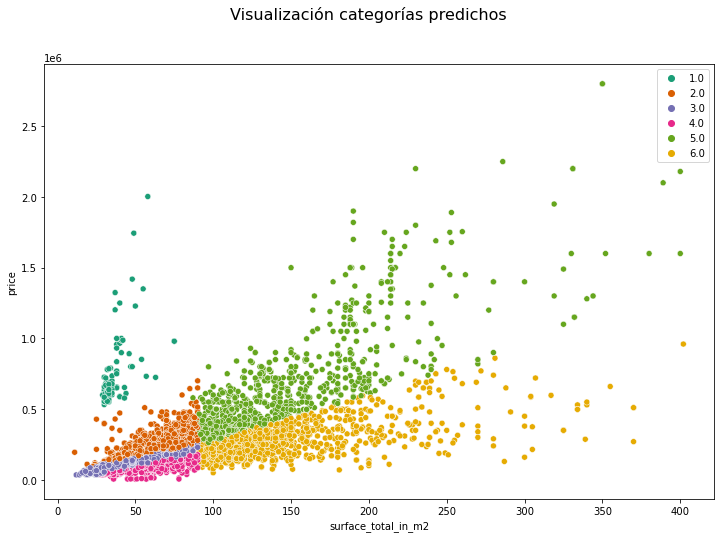

In [202]:
if visualizar:
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.suptitle("Visualización categorías predichos", size=16)
    sns.scatterplot(
        data=data,
        x="surface_total_in_m2",
        y="price",
        hue=predict_classes,
        palette="Dark2",
    )

In [203]:
Dicto["data"].append(data.to_dict())
data = data[features]
Dicto["data"].append(data.to_dict())

-------
## CONJUNTO 2: "patron_geografico"

**ESTA SECCION TIENE UN ERROR DE LOGICA EN SU DESARROLLO.**

Cuando hacemos la exploración visual de los patrones que encontramos,
vemos que las categorias definidas no devuelven patrones definidos,
devuelven una dispersión muy difícil identificar que patrón es.

Entonces elegimos manualmente los límites que separan a los patrones,
el tema fue que esos límites se fueron definiendo para cada categoría
y no fueron límites establecidos para todo el set de datos.

Tuvimos que aplicar el mismo procedimiento 5 veces, una para cada categoria:
- zona:
    - centro  
    - costa        
    - zona_periferica

- micro_centro
- grande_barato     
    
Y luego de aplicar los límites correspondientes quedamos solamente:
- zona:
    - centro  
    - costa        
    - zona_periferica
   
### VISUALIZACION (celda: 78)

In [204]:
# limpieza outliers
data.drop(
    (data.loc[data.categoria_final == 1].loc[data.rooms == 3]).index, inplace=True
)
data.drop(
    (data.loc[data.categoria_final == 5].loc[data.rooms == 1]).index, inplace=True
)

Dicto["data"].append(data.to_dict())

-------------------------------
                            PATRONES IDENTIFICADOS SEGUN CONUJUNTO 1
                            
-----                          

In [205]:
data = pd.DataFrame(Dicto["data"][-1])
mask = data.eval("categoria_final == 1")
data.loc[mask, "patron_geografico"] = "micro_centro"

mask = data.eval("categoria_final == 2 or categoria_final == 5")
data.loc[mask, "patron_geografico"] = "zona_costa"

mask = data.eval("categoria_final == 3")
data.loc[mask, "patron_geografico"] = "zona_centro"

mask = data.eval("categoria_final == 4")
data.loc[mask, "patron_geografico"] = "zona_periferica"

data.patron_geografico.fillna(data.etiqueta_final, inplace=True)

data.patron_geografico.value_counts()

zona_centro        4811
zona_costa         2260
grande_barato      1596
zona_periferica    1577
micro_centro        123
Name: patron_geografico, dtype: int64

----
                                    VISUALIZACION

----

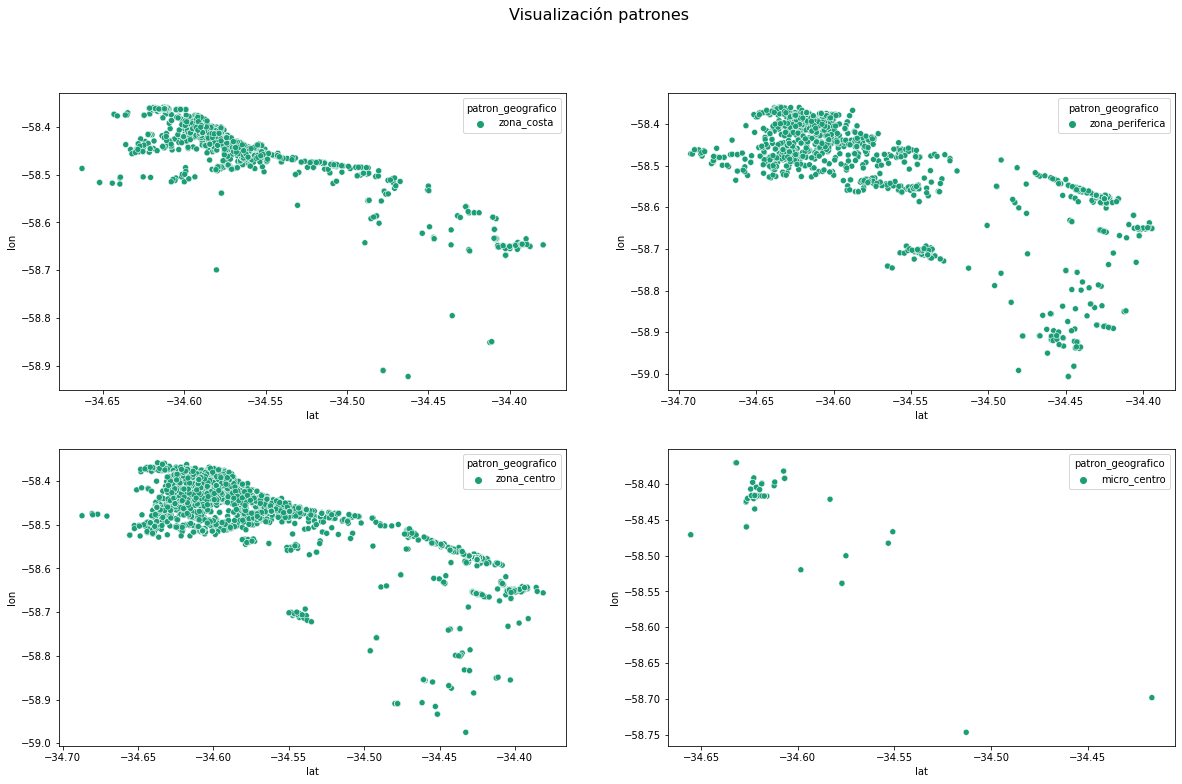

In [206]:
lista = list(data.patron_geografico.unique())
lista.remove("grande_barato")

if visualizar_extra:
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
    fig.suptitle("Visualización patrones", size=16)

    suma = 0
    for i in range(2):
        for j in range(2):
            mask = data.patron_geografico == lista[suma]
            sns.scatterplot(
                x="lat",
                y="lon",
                data=data[mask],
                ax=ax[i][j],
                palette="Dark2",
                hue="patron_geografico",
            )
            suma += 1

-------
                                    ZONA CENTRO
                        
---

zona_centro    4811
Name: patron_geografico, dtype: int64

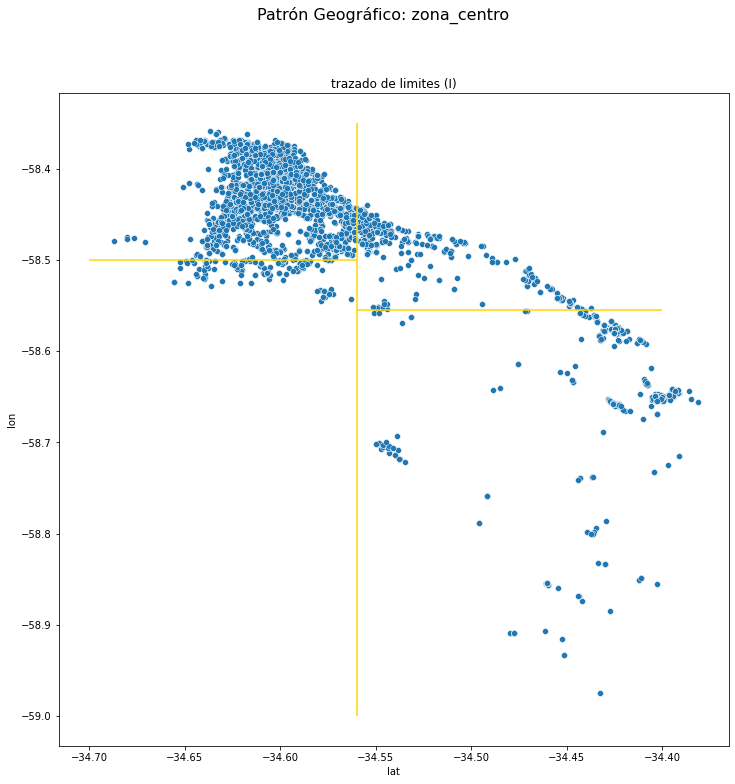

In [207]:
patron = data[data.patron_geografico == "zona_centro"].copy()
if visualizar_extra:
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.suptitle("Patrón Geográfico: zona_centro", size=16)
    sns.scatterplot(data=patron, x="lat", y="lon").set(title="trazado de limites (I)")
    plt.vlines(-34.56, -59, -58.35, linestyles="solid", color="gold")
    plt.hlines(-58.5, -34.7, -34.56, linestyles="solid", color="gold")
    plt.hlines(-58.555, -34.56, -34.4, linestyles="solid", color="gold")
patron.patron_geografico.value_counts()

In [208]:
def b_m_coeficientes(x1_y1, x2_y2):
    m = x1_y1[1] - x2_y2[1]
    m = m / (x1_y1[0] - x2_y2[0])
    b = x1_y1[1] - m * x1_y1[0]
    return [b, m]


def generar_recta(serie_x, coeficientes):
    termino = []
    for i, elemento in enumerate(serie_x.values):
        termino.append(elemento * coeficientes[1] + coeficientes[0])

    dicc = dict(zip(serie_x.index, termino))
    serie_y = pd.Series(dicc)

    return serie_y

zona_centro        3606
zona_costa         1097
zona_periferica     108
Name: patron_geografico, dtype: int64

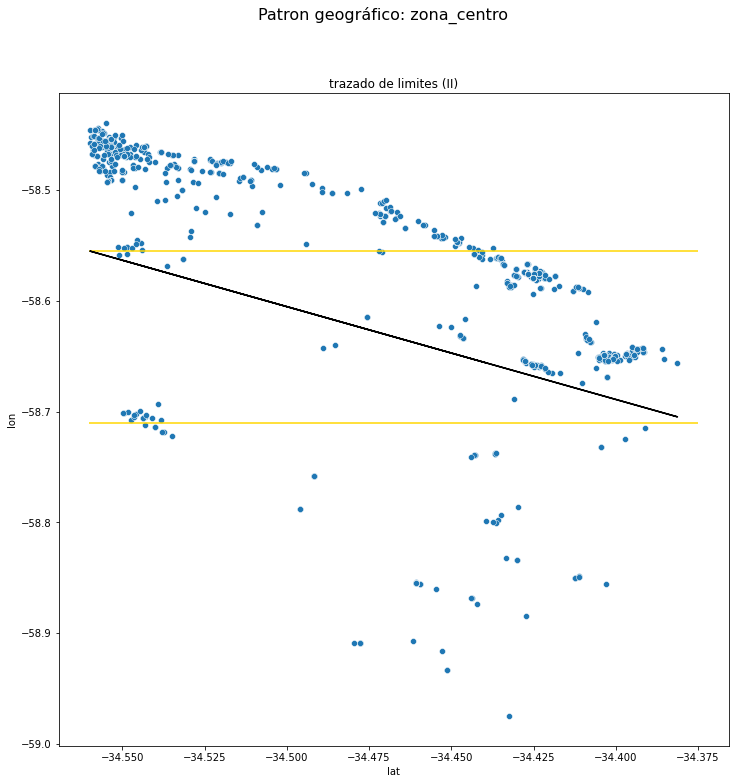

In [209]:
patron["zona_derecha"] = patron.eval("lat > -34.56")
indice = patron[patron.zona_derecha == True].index
if visualizar_extra:
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.suptitle("Patron geográfico: zona_centro", size=16)
    sns.scatterplot(data=patron.loc[indice], x="lat", y="lon").set(
        title="trazado de limites (II)"
    )

serie_x = patron.loc[indice, "lat"]

# modificable:
x1_y1 = [-34.56, -58.555]
x2_y2 = [-34.375, -58.71]
if visualizar_extra:
    plt.hlines(x1_y1[1], x1_y1[0], x2_y2[0], linestyles="solid", color="gold")
    # P_2 = (x2, y2)
    plt.hlines(x2_y2[1], x1_y1[0], x2_y2[0], linestyles="solid", color="gold")
    # P_1 = (x1, y1)


coeficientes = b_m_coeficientes(x1_y1, x2_y2)
serie_y = generar_recta(serie_x, coeficientes)
if visualizar_extra:
    plt.plot(serie_x.values, serie_y.values, color="black")

#### MASCARA PATRON ZONA COSTA
mask_bool = patron.loc[indice, "lon"] > serie_y
# patron.loc[indice].loc[mask_bool, 'patron_geografico'] = 'zona_costa'

# mask_bool = patron.loc[indice, 'lon'] <= serie_y
# patron.loc[indice, 'patron_geografico'].loc[mask_bool] = 'hola'# no funciona

lista_completa = list(patron.index)
lista_por_completar = list(mask_bool.index)
# print ('la diferencia es de {}'.format(len(lista_completa) - len(lista_por_completar)))#check
diferencia_1 = set(lista_completa).difference(set(lista_por_completar))

diferencia_1
valores = [False] * len(diferencia_1)

mask_bool_2 = pd.Series(dict(zip(diferencia_1, valores)))
mask_bool = mask_bool.append(mask_bool_2)
patron.loc[mask_bool, "patron_geografico"] = "zona_costa"

#### MASCARA PATRON ZONA PERIFERICA

mask_bool = patron.loc[indice, "lon"] <= serie_y
lista_completa = list(patron.index)
lista_por_completar = list(mask_bool.index)
diferencia_1 = set(lista_completa).difference(set(lista_por_completar))

diferencia_1
valores = [False] * len(diferencia_1)

mask_bool_2 = pd.Series(dict(zip(diferencia_1, valores)))
mask_bool = mask_bool.append(mask_bool_2)
patron.loc[mask_bool, "patron_geografico"] = "zona_periferica"

patron.drop("zona_derecha", axis=1, inplace=True)
patron.patron_geografico.value_counts()

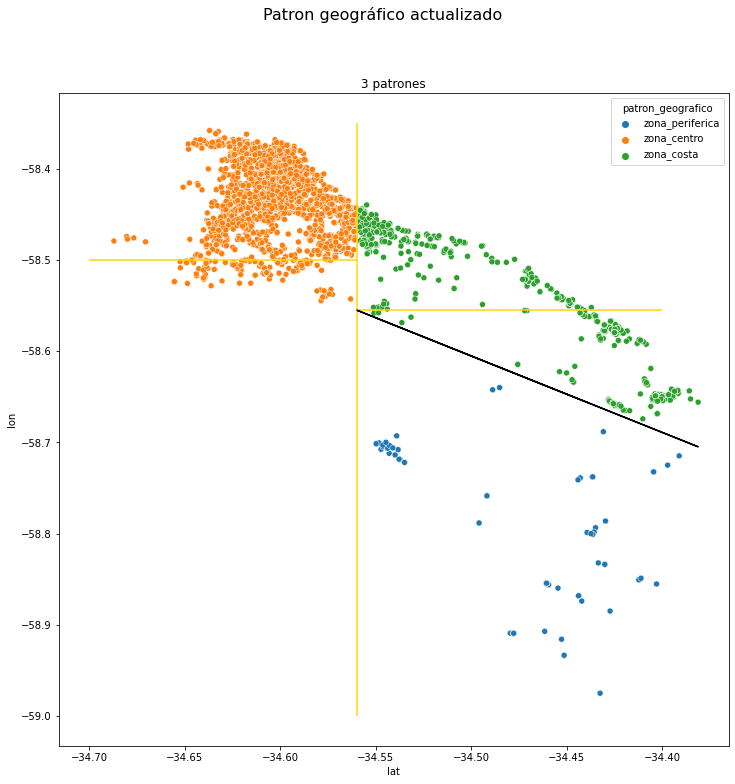

In [210]:
if visualizar_extra:
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.suptitle("Patron geográfico actualizado", size=16)
    sns.scatterplot(data=patron, x="lat", y="lon", hue="patron_geografico").set(
        title="3 patrones"
    )

    plt.vlines(-34.56, -59, -58.35, linestyles="solid", color="gold")
    plt.hlines(-58.5, -34.7, -34.56, linestyles="solid", color="gold")
    plt.hlines(-58.555, -34.56, -34.4, linestyles="solid", color="gold")
    plt.plot(serie_x.values, serie_y.values, color="black")

In [211]:
mask = data.patron_geografico == "zona_centro"

data.loc[mask, "patron_geografico"] = patron.patron_geografico
data.loc[mask, "patron_geografico"].value_counts()

zona_centro        3606
zona_costa         1097
zona_periferica     108
Name: patron_geografico, dtype: int64

--------
                                            ZONA COSTA
                                            
---

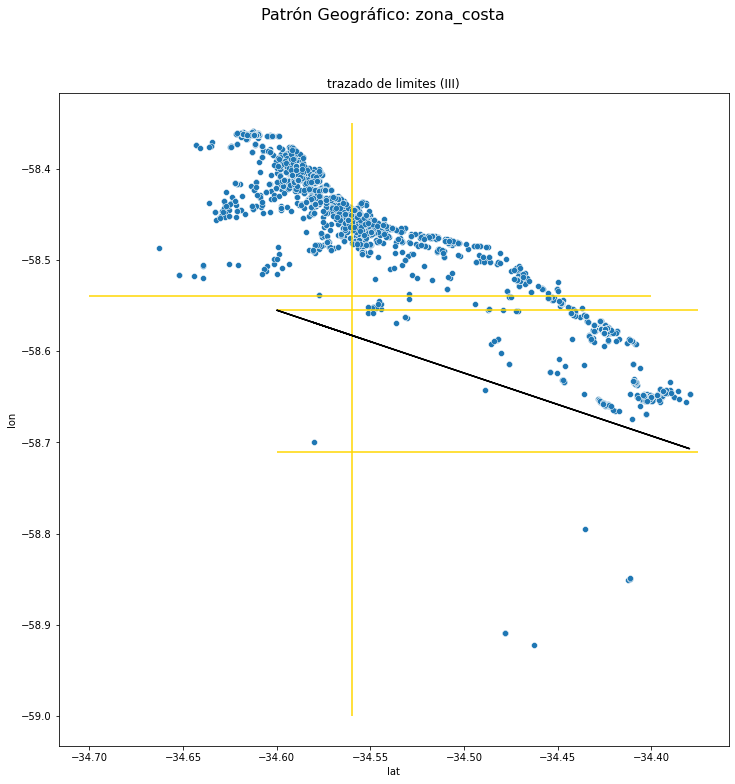

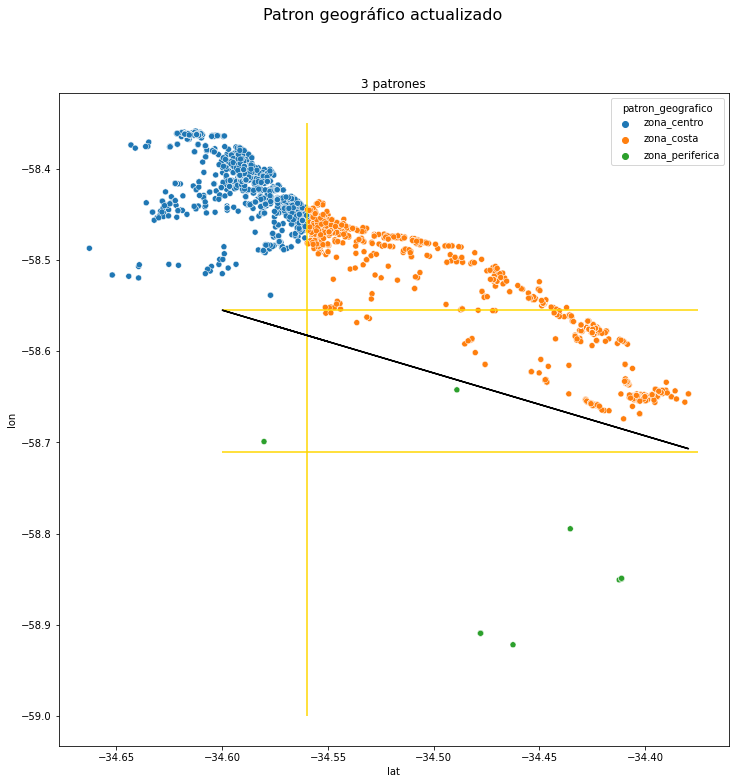

In [212]:
patron = data[data.patron_geografico == "zona_costa"].copy()

if visualizar_extra:
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.suptitle("Patrón Geográfico: zona_costa", size=16)
    sns.scatterplot(data=patron, x="lat", y="lon").set(title="trazado de limites (III)")
    plt.hlines(-58.54, -34.7, -34.4, linestyles="solid", color="gold")
    plt.vlines(-34.56, -59, -58.35, linestyles="solid", color="gold")

patron.patron_geografico.value_counts()

patron["zona_derecha"] = patron.eval("lat > -34.56")
indice = patron[patron.zona_derecha == True].index


# modificable:
x1_y1 = [-34.60, -58.555]
x2_y2 = [-34.375, -58.71]

mask_x = patron.lat >= x1_y1[0]
serie_x = patron.loc[mask_x, "lat"]

if visualizar_extra:
    plt.hlines(x1_y1[1], x1_y1[0], x2_y2[0], linestyles="solid", color="gold")
    # P_2 = (x2, y2)
    plt.hlines(x2_y2[1], x1_y1[0], x2_y2[0], linestyles="solid", color="gold")
    # P_1 = (x1, y1)

coeficientes = b_m_coeficientes(x1_y1, x2_y2)

serie_y = generar_recta(serie_x, coeficientes)
if visualizar_extra:
    plt.plot(serie_x.values, serie_y.values, color="black")


#### MASCARA CENTRO

mask = patron.zona_derecha

patron.loc[~mask, "patron_geografico"] = "zona_centro"

#### MASCARA PATRON ZONA PERIFERICA

mask_bool = patron.loc[mask_x, "lon"] <= serie_y
lista_completa = list(patron.index)
lista_por_completar = list(mask_bool.index)
diferencia_1 = set(lista_completa).difference(set(lista_por_completar))

valores = [False] * len(diferencia_1)

mask_bool_2 = pd.Series(dict(zip(diferencia_1, valores)))
mask_bool = mask_bool.append(mask_bool_2)
patron.loc[mask_bool, "patron_geografico"] = "zona_periferica"

patron.drop("zona_derecha", axis=1, inplace=True)

if visualizar_extra:
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.suptitle("Patron geográfico actualizado", size=16)
    sns.scatterplot(data=patron, x="lat", y="lon", hue="patron_geografico").set(
        title="3 patrones"
    )

    plt.hlines(x1_y1[1], x1_y1[0], x2_y2[0], linestyles="solid", color="gold")
    # P_2 = (x2, y2)
    plt.hlines(x2_y2[1], x1_y1[0], x2_y2[0], linestyles="solid", color="gold")
    # P_1 = (x1, y1)
    plt.vlines(-34.56, -59, -58.35, linestyles="solid", color="gold")
    plt.plot(serie_x.values, serie_y.values, color="black")

In [213]:
patron.patron_geografico.value_counts()

zona_centro        1687
zona_costa         1659
zona_periferica      11
Name: patron_geografico, dtype: int64

In [214]:
mask = data.patron_geografico == "zona_costa"

data.loc[mask, "patron_geografico"] = patron.patron_geografico
data.loc[mask, "patron_geografico"].value_counts()

zona_centro        1687
zona_costa         1659
zona_periferica      11
Name: patron_geografico, dtype: int64

---------------
                                            ZONA PERIFÉRICA

---

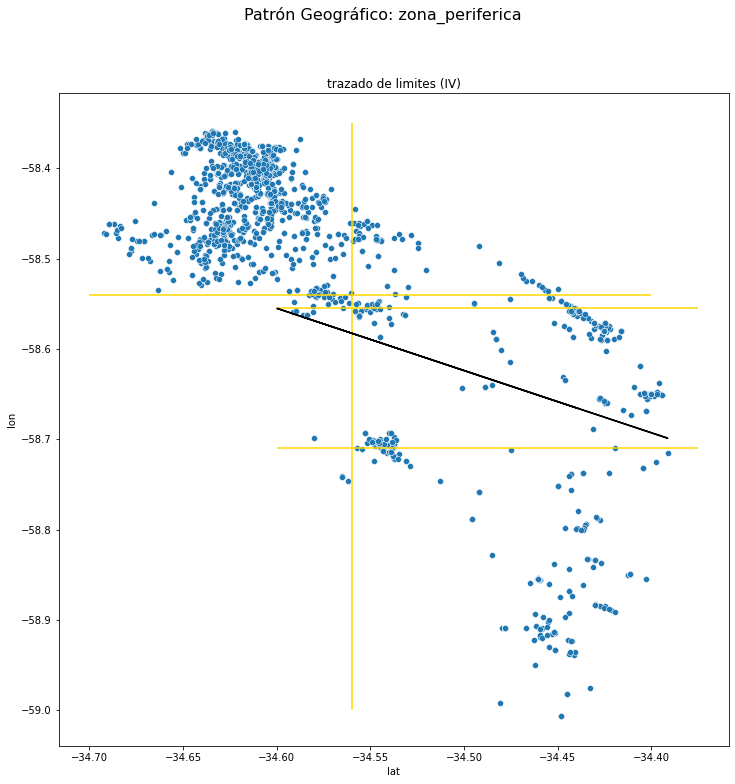

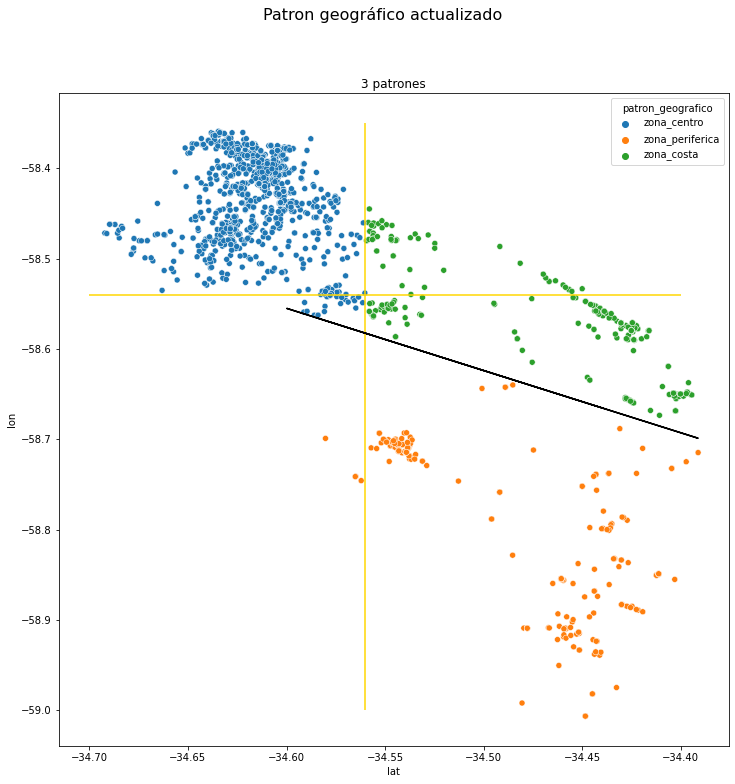

In [215]:
patron = data[data.patron_geografico == "zona_periferica"].copy()

if visualizar_extra:
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.suptitle("Patrón Geográfico: zona_periferica", size=16)
    sns.scatterplot(data=patron, x="lat", y="lon").set(title="trazado de limites (IV)")
    plt.hlines(-58.54, -34.7, -34.4, linestyles="solid", color="gold")
    plt.vlines(-34.56, -59, -58.35, linestyles="solid", color="gold")

patron["zona_derecha"] = patron.eval("lat > -34.56")
indice = patron[patron.zona_derecha == True].index

# modificable:
x1_y1 = [-34.60, -58.555]
x2_y2 = [-34.375, -58.71]

mask_x = patron.lat >= x1_y1[0]
serie_x = patron.loc[mask_x, "lat"]

if visualizar_extra:
    plt.hlines(x1_y1[1], x1_y1[0], x2_y2[0], linestyles="solid", color="gold")
    # P_2 = (x2, y2)
    plt.hlines(x2_y2[1], x1_y1[0], x2_y2[0], linestyles="solid", color="gold")
    # P_1 = (x1, y1)

coeficientes = b_m_coeficientes(x1_y1, x2_y2)

serie_y = generar_recta(serie_x, coeficientes)

if visualizar_extra:
    plt.plot(serie_x.values, serie_y.values, color="black")

########################

#### MASCARA PATRON ZONA COSTA

mask_bool = patron.loc[mask_x, "lon"] > serie_y
lista_completa = list(patron.index)
lista_por_completar = list(mask_bool.index)
diferencia_1 = set(lista_completa).difference(set(lista_por_completar))

valores = [False] * len(diferencia_1)

mask_bool_2 = pd.Series(dict(zip(diferencia_1, valores)))
mask_bool = mask_bool.append(mask_bool_2)
patron.loc[mask_bool, "patron_geografico"] = "zona_costa"

#### MASCARA CENTRO

mask = patron.zona_derecha

patron.loc[~mask, "patron_geografico"] = "zona_centro"

#### MASCARA PATRON ZONA PERIFERICA

mask_bool = patron.loc[mask_x, "lon"] <= serie_y
lista_completa = list(patron.index)
lista_por_completar = list(mask_bool.index)
diferencia_1 = set(lista_completa).difference(set(lista_por_completar))

diferencia_1
valores = [False] * len(diferencia_1)

mask_bool_2 = pd.Series(dict(zip(diferencia_1, valores)))
mask_bool = mask_bool.append(mask_bool_2)
patron.loc[mask_bool, "patron_geografico"] = "zona_periferica"

patron.drop("zona_derecha", axis=1, inplace=True)

if visualizar_extra:
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.suptitle("Patron geográfico actualizado", size=16)
    sns.scatterplot(data=patron, x="lat", y="lon", hue="patron_geografico").set(
        title="3 patrones"
    )

    plt.hlines(-58.54, -34.7, -34.4, linestyles="solid", color="gold")
    plt.vlines(-34.56, -59, -58.35, linestyles="solid", color="gold")
    plt.plot(serie_x.values, serie_y.values, color="black")

In [216]:
mask = data.patron_geografico == "zona_periferica"

data.loc[mask, "patron_geografico"] = patron.patron_geografico
data.loc[mask, "patron_geografico"].value_counts()

zona_centro        1101
zona_costa          316
zona_periferica     279
Name: patron_geografico, dtype: int64

In [217]:
data.patron_geografico.value_counts()

zona_centro        6394
zona_costa         1975
grande_barato      1596
zona_periferica     279
micro_centro        123
Name: patron_geografico, dtype: int64

---------------
                                GRANDE_BARATO Y MICRO_CENTRO
                                
-------                                

In [218]:
patron = data[data.patron_geografico == "grande_barato"].copy()

patron["zona_derecha"] = patron.eval("lat > -34.56")
indice = patron[patron.zona_derecha == True].index

# modificable:
x1_y1 = [-34.60, -58.555]
x2_y2 = [-34.375, -58.71]

mask_x = patron.lat >= x1_y1[0]
serie_x = patron.loc[mask_x, "lat"]

coeficientes = b_m_coeficientes(x1_y1, x2_y2)

serie_y = generar_recta(serie_x, coeficientes)

########################

#### MASCARA PATRON ZONA COSTA

mask_bool = patron.loc[mask_x, "lon"] > serie_y
lista_completa = list(patron.index)
lista_por_completar = list(mask_bool.index)
diferencia_1 = set(lista_completa).difference(set(lista_por_completar))

diferencia_1
valores = [False] * len(diferencia_1)

mask_bool_2 = pd.Series(dict(zip(diferencia_1, valores)))
mask_bool = mask_bool.append(mask_bool_2)
patron.loc[mask_bool, "patron_geografico"] = "zona_costa"

#### MASCARA CENTRO

mask = patron.zona_derecha

patron.loc[~mask, "patron_geografico"] = "zona_centro"

#### MASCARA PATRON ZONA PERIFERICA

mask_bool = patron.loc[mask_x, "lon"] <= serie_y
lista_completa = list(patron.index)
lista_por_completar = list(mask_bool.index)
diferencia_1 = set(lista_completa).difference(set(lista_por_completar))

diferencia_1
valores = [False] * len(diferencia_1)

mask_bool_2 = pd.Series(dict(zip(diferencia_1, valores)))
mask_bool = mask_bool.append(mask_bool_2)
patron.loc[mask_bool, "patron_geografico"] = "zona_periferica"


patron.drop("zona_derecha", axis=1, inplace=True)

In [219]:
mask = data.patron_geografico == "grande_barato"

data.loc[mask, "patron_geografico"] = patron.patron_geografico
data.loc[mask, "patron_geografico"].value_counts()

zona_centro        969
zona_costa         512
zona_periferica    115
Name: patron_geografico, dtype: int64

In [220]:
patron = data[data.patron_geografico == "micro_centro"].copy()

patron["zona_derecha"] = patron.eval("lat > -34.56")
indice = patron[patron.zona_derecha == True].index

# modificable:
x1_y1 = [-34.60, -58.555]
x2_y2 = [-34.375, -58.71]

mask_x = patron.lat >= x1_y1[0]
serie_x = patron.loc[mask_x, "lat"]


coeficientes = b_m_coeficientes(x1_y1, x2_y2)
serie_y = generar_recta(serie_x, coeficientes)


########################

#### MASCARA PATRON ZONA COSTA

mask_bool = patron.loc[mask_x, "lon"] > serie_y
lista_completa = list(patron.index)
lista_por_completar = list(mask_bool.index)
diferencia_1 = set(lista_completa).difference(set(lista_por_completar))

diferencia_1
valores = [False] * len(diferencia_1)

mask_bool_2 = pd.Series(dict(zip(diferencia_1, valores)))
mask_bool = mask_bool.append(mask_bool_2)
patron.loc[mask_bool, "patron_geografico"] = "zona_costa"

#### MASCARA CENTRO

mask = patron.zona_derecha

patron.loc[~mask, "patron_geografico"] = "zona_centro"

#### MASCARA PATRON ZONA PERIFERICA

mask_bool = patron.loc[mask_x, "lon"] <= serie_y
lista_completa = list(patron.index)
lista_por_completar = list(mask_bool.index)
diferencia_1 = set(lista_completa).difference(set(lista_por_completar))

diferencia_1
valores = [False] * len(diferencia_1)

mask_bool_2 = pd.Series(dict(zip(diferencia_1, valores)))
mask_bool = mask_bool.append(mask_bool_2)
patron.loc[mask_bool, "patron_geografico"] = "zona_periferica"


patron.drop("zona_derecha", axis=1, inplace=True)

In [221]:
mask = data.patron_geografico == "micro_centro"

data.loc[mask, "patron_geografico"] = patron.patron_geografico
data.loc[mask, "patron_geografico"].value_counts()

zona_centro        119
zona_periferica      2
zona_costa           2
Name: patron_geografico, dtype: int64

In [222]:
data.loc[(data["patron_geografico"] == "zona_centro"), "categoria_geografica"] = 1
data.loc[(data["patron_geografico"] == "zona_costa"), "hue_2"] = 2
data.loc[(data["patron_geografico"] == "zona_periferica"), "hue_3"] = 3

data["categoria_geografica"].fillna(data["hue_2"], inplace=True)
data["categoria_geografica"].fillna(data["hue_3"], inplace=True)
data.drop(["hue_2", "hue_3"], axis=1, inplace=True)

### VISUALIZACIÓN DEL LOS PATRONES ACTUALIZADOS

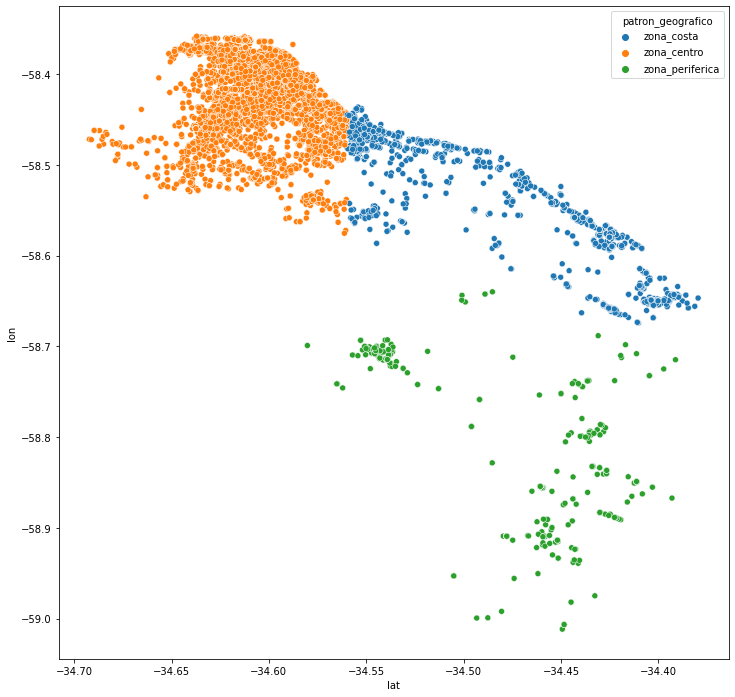

In [223]:
if visualizar:
    fig = plt.figure(figsize=(12, 12))
    sns.scatterplot(data=data, x="lat", y="lon", hue="patron_geografico")

In [224]:
data.patron_geografico.value_counts()

zona_centro        7482
zona_costa         2489
zona_periferica     396
Name: patron_geografico, dtype: int64

----
## CONCLUSIONES 1

ANALISIS DE ROOMS

VISUALIZACION DEL CONJUNTO 1

--------------
                                    ANALISIS DE ROOMS
                                    
----------------                                    

In [225]:
data[data.patron_geografico == "zona_centro"].rooms.value_counts()

1.0    2077
3.0    2008
2.0    1981
4.0    1416
Name: rooms, dtype: int64

zona_centro        72.17
zona_costa         24.01
zona_periferica     3.82
Name: patron_geografico, dtype: float64

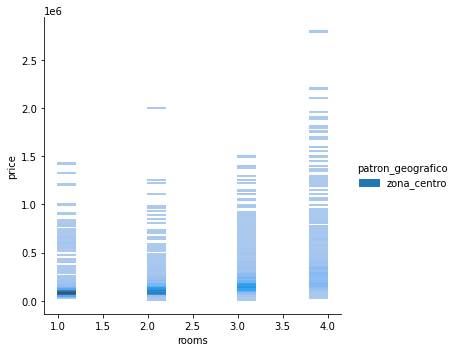

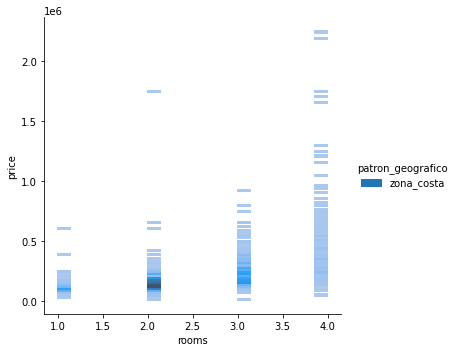

In [226]:
display((data.patron_geografico.value_counts(normalize=True) * 100).round(2))

if visualizar_extra:
    mask_1 = data.patron_geografico == "zona_centro"
    sns.displot(
        data=data[mask_1], x="rooms", y="price", hue="patron_geografico", ax=ax
    )  # .set(title='todas las zonas')
    mask_1 = data.patron_geografico == "zona_costa"
    sns.displot(data=data[mask_1], x="rooms", y="price", hue="patron_geografico", ax=ax)

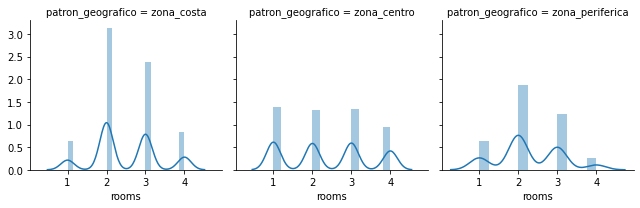

In [227]:
if visualizar:
    g = sns.FacetGrid(data, col="patron_geografico", margin_titles=True)
    g.map(sns.distplot, "rooms")

----------------------------
                              VISUALIZACIÓN CONJUNTO 1: PATRONES DE PRECIO

-----------------------------

CONCLUSIÓN DE LOS GRÁFICOS: 
 - Los apartamentos de la categoria chico_superior, son en su mayoría de dos ambientes alrededor de 60m2 totales.
 - Los apartamentos más económicos de la categoria chico_medio, son de un ambiente con 35m2 de superficie total.
 - Los apartamentos de mayor superficie y más económicos, son pequeños y con muchos ambientes (próximos a 100m2), aunque hay    un en algunos casos son monoambientes de gran superficie (hasta 300m2).


<Figure size 432x288 with 0 Axes>

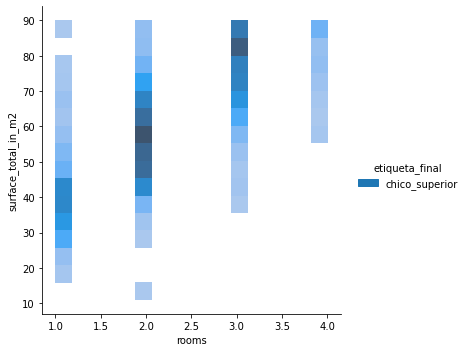

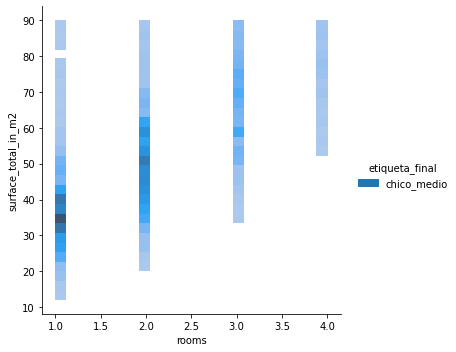

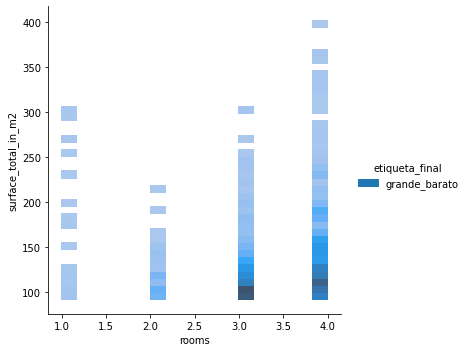

In [228]:
if visualizar_extra:
    plt.suptitle("Exploracion de la superficie segun etiqueta CONJUNTO 1")
    mask_1 = data.categoria_final == 2
    sns.displot(
        data=data[mask_1],
        x="rooms",
        y="surface_total_in_m2",
        hue="etiqueta_final",
        ax=ax,
    )  # .set(title='todas las zonas')
    mask_1 = data.categoria_final == 3
    sns.displot(
        data=data[mask_1],
        x="rooms",
        y="surface_total_in_m2",
        hue="etiqueta_final",
        ax=ax,
    )
    mask_1 = data.categoria_final == 6
    sns.displot(
        data=data[mask_1],
        x="rooms",
        y="surface_total_in_m2",
        hue="etiqueta_final",
        ax=ax,
    )

    print(
        """CONCLUSIÓN DE LOS GRÁFICOS: 
 - Los apartamentos de la categoria chico_superior, son en su mayoría de dos ambientes alrededor de 60m2 totales.
 - Los apartamentos más económicos de la categoria chico_medio, son de un ambiente con 35m2 de superficie total.
 - Los apartamentos de mayor superficie y más económicos, son pequeños y con muchos ambientes (próximos a 100m2), aunque hay    un en algunos casos son monoambientes de gran superficie (hasta 300m2)."""
    )

------------------
# 3) <u>CATEGORIAS MACHINE LEARNING

### Clusters DBSCAN

- CREACION DEL MODELO Y AJUSTE DE PARAMETROS
- CREACION DE CATEGORIA Y LIMPIEZA DE OUTLIERS
- VISUALIZACION    
    
### Cluster Jerarquico

- CREACION DE LA MATRIZ DE FEATURES
- COEFICIENTE COFENÉTICO Y MODOS



In [229]:
Dicto["data"].append(data.to_dict())
data.drop(["expenses", "floor"], axis=1, inplace=True)

### Clusters DBSCAN

--------------
                            CREACION DEL MODELO Y AJUSTE DE PARAMETROS

--------

In [230]:
mask_feature = (data_info(data)["dtype"] != "object").values

X = data.loc[:, mask_feature]

X = StandardScaler().fit_transform(X)

X = pd.DataFrame(
    X, columns=data.loc[:, mask_feature].columns, index=data.loc[:, mask_feature].index
)

X.dropna(inplace=True)

data = data.loc[data.index.intersection(X.index)]

In [231]:
data_info(X)

df de data                columna  Nan    dtype  count  pct_nan  count_unique
index                                                                        
0                             lat    0  float64  10140      0.0          5612
1                             lon    0  float64  10140      0.0          5588
2                           price    0  float64  10140      0.0          2020
3             surface_total_in_m2    0  float64  10140      0.0           272
4           surface_covered_in_m2    0  float64  10140      0.0           238
5                           rooms    0  float64  10140      0.0             4
6                 categoria_final    0  float64  10140      0.0             6
7            categoria_geografica    0  float64  10140      0.0             3

----
                               CREACION DEL MODELO Y AJUSTE DE LOS PARAMETROS
                               
-----                               

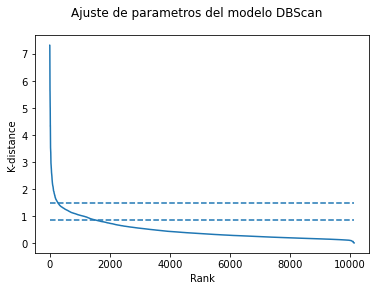

In [232]:
# CREACION MODELO
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1, min_samples=25)

# AJUSTE DE PARAMETROS
from scipy.spatial.distance import pdist, squareform

minPts = 25
# 2D
k = minPts - 1
D = squareform(pdist(X))
k_distances = np.zeros(D.shape[0])

for i in range(D.shape[0]):
    distances = np.sort(D[i])
    k_distances[i] = distances[k]

k_distances = np.sort(k_distances)
k_distances = k_distances[::-1]

if visualizar:
    plt.suptitle("Ajuste de parametros del modelo DBScan")
    plt.plot(k_distances)
    plt.xlabel("Rank")
    plt.ylabel("K-distance")
    plt.hlines([1.5, 0.85], 0, D.shape[0], linestyles="dashed");

In [233]:
y_pred = dbscan.fit_predict(X)

In [234]:
print("# cantidad de categorias")

print(pd.Series(pd.Series((dbscan.labels_)).unique()).count())

# cantidad de categorias
11


In [235]:
print("# cantidad de outliers")
print((y_pred == -1).sum())

# cantidad de outliers
609


-------
                               CREACION DE CATEGORIA Y LIMPIEZA DE OUTLIERS

----------

In [236]:
mask_index = data.index.intersection(X.index)
data.loc[mask_index, "categoria_dbscan"] = y_pred
data.drop(data[data.categoria_dbscan == -1].index, inplace=True)

---------
                                                VISUALIZACION

-----

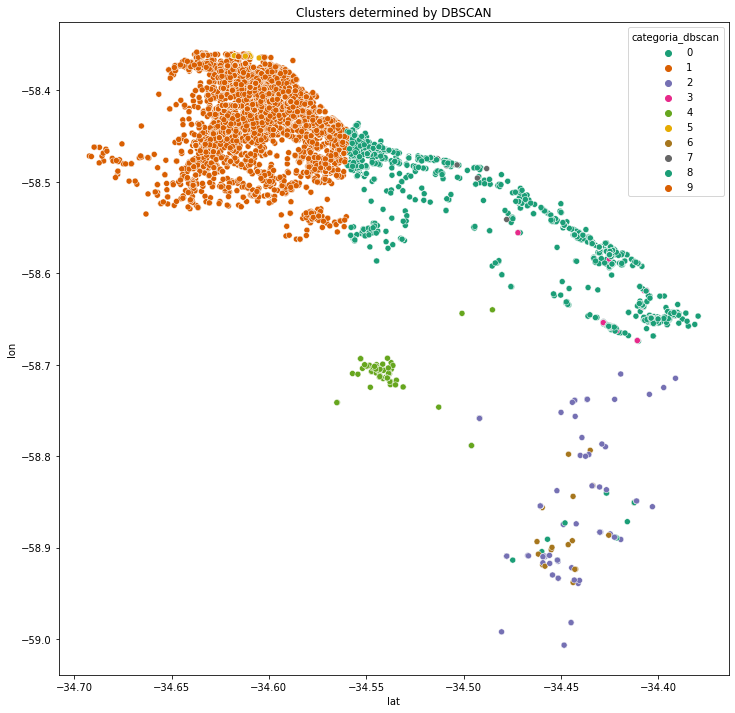

In [237]:
if visualizar_extra:
    plt.figure(figsize=(12, 12))
    sns.scatterplot(
        data=data, x="lat", y="lon", hue="categoria_dbscan", palette="Dark2"
    )
    plt.title("Clusters determined by DBSCAN")

### CLUSTER JERÁRQUICO

---------------
                                    CREACION DE MATRIZ DE FEATURES
                        
--------                        

In [238]:
# creacion de label en el dataset
mask_feature = (data_info(data)["dtype"] != "object").values

X = data.loc[:, mask_feature]

X = StandardScaler().fit_transform(X)

X = pd.DataFrame(X, columns=data.loc[:, mask_feature].columns, index=data.index)

In [239]:
display(X.head())

lat       lon     price  surface_total_in_m2  surface_covered_in_m2  \
17  2.138633 -1.641185  0.854863             2.933609               0.542103   
19 -0.228084  0.696747  1.092681             0.948320               1.125580   
21 -0.371675  0.637501  0.552494             1.334348               0.380026   
29 -0.980512  0.000124 -0.775891            -0.733660              -0.592435   
33  2.138633 -1.641185  0.922811             3.209343               0.704180   

       rooms  categoria_final  categoria_geografica  categoria_dbscan  
17  0.650963         1.969543              1.400087         -0.828626  
19  0.650963         1.158705             -0.570996          0.038484  
21  1.657015         1.969543             -0.570996          0.038484  
29 -0.355090         0.347867             -0.570996          0.038484  
33  0.650963         1.969543              1.400087         -0.828626

In [240]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist

-----------------------
                                COEFICIENTE COFENETICO Y MODOS
                                
------------

In [241]:
lista_modos = ["ward", "average", "complete", "single"]

for elemento in lista_modos:
    Z = linkage(X, elemento)
    c, dist = cophenet(Z, pdist(X))
    print('coeficiente Cophenetic: "{}"" = {}'.format(elemento, "%.2f" % c))

coeficiente Cophenetic: "ward"" = 0.67
coeficiente Cophenetic: "average"" = 0.87
coeficiente Cophenetic: "complete"" = 0.77
coeficiente Cophenetic: "single"" = 0.68


------
                                        DENDOGRAMA

-----

In [242]:
Z = linkage(X, "average")

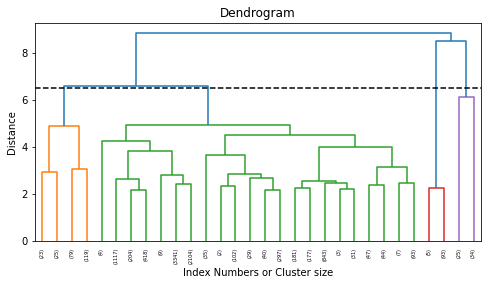

In [243]:
plt.figure(figsize=[8, 4])
plt.title("Dendrogram")
plt.xlabel("Index Numbers or Cluster size")
plt.ylabel("Distance")

ax = plt.axes()

dendrogram(
    Z,
    leaf_rotation=90.0,
    leaf_font_size=5.0,
    color_threshold=6.5,
    truncate_mode="lastp",
    ax=ax,
)


plt.hlines(6.5, 0, X.shape[0] * 100, linestyle="--", colors="black")
plt.show()

In [244]:
labels = fcluster(Z, 3, criterion="maxclust")
# data.loc[:, 'categoria_jerarquica_3'] = labels

labels = fcluster(Z, 4, criterion="maxclust")
data.loc[:, "categoria_jerarquica_4"] = labels

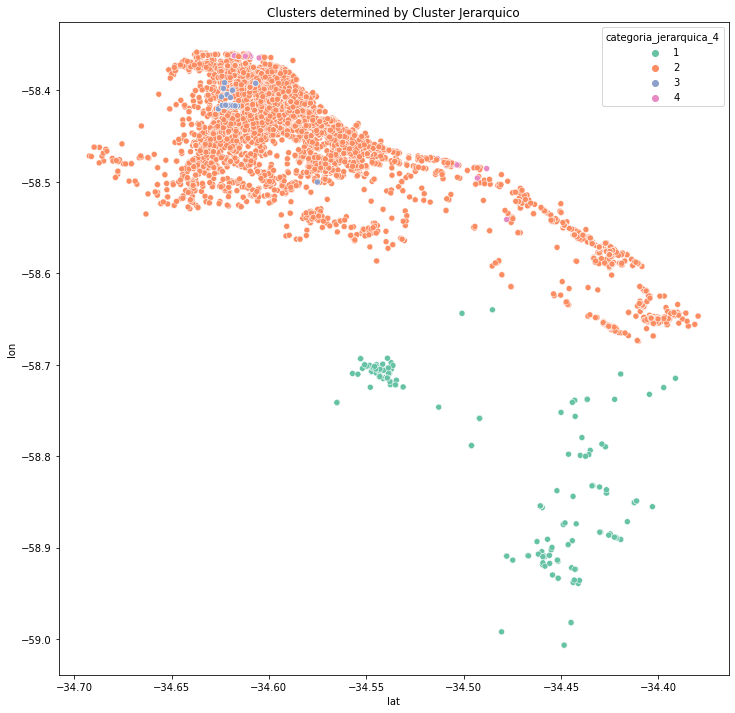

In [245]:
if visualizar_extra:
    plt.figure(figsize=(12, 12))
    sns.scatterplot(
        data=data, x="lat", y="lon", hue="categoria_jerarquica_4", palette="Set2"
    )
    plt.title("Clusters determined by Cluster Jerarquico")

---

# 4) <u>CONCLUSION 2

***Logramos identificar una gran diferecia entre diseñar categorías en 2D y clusterizar con multiples features.***

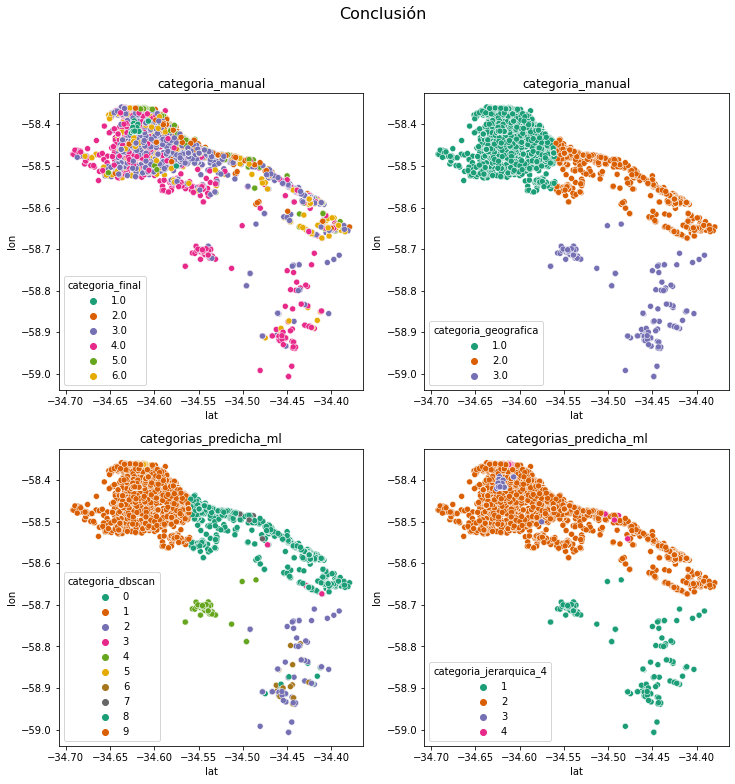

In [246]:
if visualizar:
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle("Conclusión", size=16)

    lista_hue = [
        "categoria_final",
        "categoria_geografica",
        "categoria_dbscan",
        "categoria_jerarquica_4",
    ]
    suma = 0
    for i in range(2):
        for j in range(2):
            label = ["categoria_manual", "categorias_predicha_ml"]
            sns.scatterplot(
                data=data,
                x="lat",
                y="lon",
                hue=lista_hue[suma],
                palette="Dark2",
                ax=ax[i][j],
            ).set(title=label[i])
            suma += 1

----------
A partir de la exploración de los datos, limpieza del dataset, aplicando criterios propios de categorización (I&D), hemos podido diseñar **conjuntos** de categorías. 

Cada **conjunto** posee un serie de categorias ordenadas, en este caso representan distintas características del set de datos.

    - En el conjunto 1: las características son según la ubicación dentro del scatterplot de superficie y precio
    
    - En el conjunto 2: las características son según la ubicación en el mapa
    
Luego de construir los conjuntos hemos implementado algoritmos de clusterización para que pudiera detectar categorías adicionales, como una *segunda dimensión* por sobre las categorias diseñadas.

De esta forma podemos identificar características que a nuestro análisis sería extremadamente dificultoso descifrar.

A modo de resumen se puede observar:

    - Categoria DBScan: 
       Muy buen trabajo para diferenciar entre el centro y la costa, además aporta características a la zona_periferica
    
    - Categoria cluster_jerarquico: 
       Diferencia la periferia con claridad, aporta características principalmente en la zona_centro, pero tambien alimenta zona_costa
    
En caso que se solicitara mayor profundidad en el desarrollo de este código, diríamos que el entrenamiento de algoritmos de regresión logística sería clave para detectar estas nuevas categorías que aportan características a las ya construidas. De esa manera en caso de que entrase data nueva podríamos detectar estos casos de interés particular. 

A continuación y a modo de anexo se procede a desarrollar un caso práctico de uso del código.

# 5) <u>ANEXO
## Caso práctico:

Simularemos que la empresa inmobiliaria nos solicita que armemos una oferta para uno de sus cliente.

Los requisitos de ese cliente son:
    
    - Dos propiedades geográficamente cerca
    - Una propiedad "oficina" que tenga la mayor cantidad de habitaciones
    - Una propiedad "dpto" que tenga 1 o 2 habitaciones
    - Quiere más de una propuesta
    - Tiene un presupuesto acotado

In [247]:
Dicto["data"].append(data.to_dict())

-----
### SELECCIÓN DE OFICINA

-----

state_name  place_name        lat        lon     price currency  \
21   Capital Federal     Palermo -34.590926 -58.411665  270500.0      USD   
53   Capital Federal   Caballito -34.623894 -58.446861  170500.0      USD   
253  Capital Federal    Belgrano -34.562084 -58.456686  340000.0      USD   
256  Capital Federal     Palermo -34.566479 -58.434075  440000.0      USD   
258  Capital Federal  Colegiales -34.576964 -58.451469  238000.0      USD   

     surface_total_in_m2  surface_covered_in_m2  rooms  categoria_final  \
21                 118.0                   73.0    4.0              6.0   
53                 100.0                   46.0    2.0              6.0   
253                128.0                  120.0    4.0              6.0   
256                175.0                  175.0    4.0              6.0   
258                126.0                  120.0    4.0              6.0   

    etiqueta_final patron_geografico  categoria_geografica  categoria_dbscan  \
21   grande_barato       zona_centro                   1.0                 1   
53   grande_barato       zona_centro                   1.0                 1   
253  grande_barato       zona_centro                   1.0                 1   
256  grande_barato       zona_centro                   1.0                 1   
258  grande_barato       zona_centro                   1.0                 1   

     categoria_jerarquica_4  
21                        2  
53                        2  
253                       2  
256                       2  
258                       2

shape[0]: publicaciones = 861
Posibles barrios:


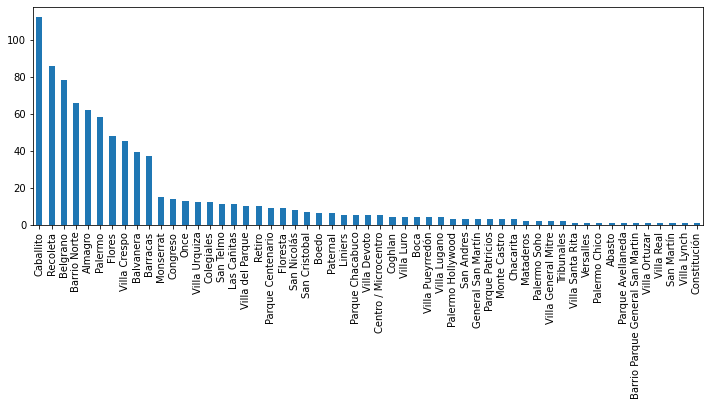

In [248]:
data = data[
    (data.etiqueta_final == "grande_barato") & (data.patron_geografico == "zona_centro")
]
display(data.head())
print("shape[0]: publicaciones = {}".format(data.shape[0]))
if visualizar_extra:
    print("Posibles barrios:")
    fig = plt.figure(figsize=(12, 4))
    data.place_name.value_counts().plot.bar()

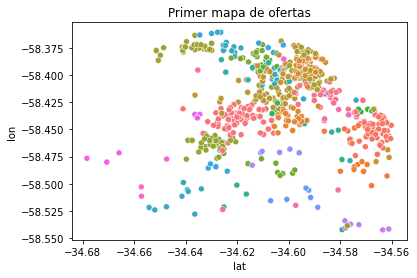

In [249]:
if visualizar_extra:
    plt.title("Primer mapa de ofertas")
    sns.scatterplot(data=data, x="lat", y="lon", hue="place_name", legend=False)

 Ditribución de precio


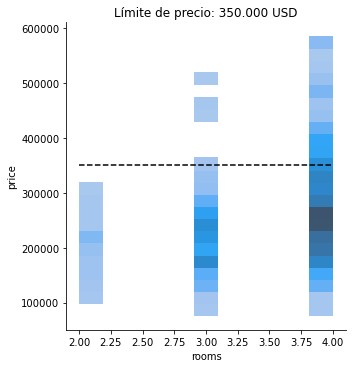

In [250]:
if visualizar:
    print(" Ditribución de precio")
    sns.displot(data=data, x="rooms", y="price").set(
        title="Límite de precio: 350.000 USD"
    )
    plt.hlines(350 * 1e3, 2, 4, linestyles="--", color="black")

In [251]:
data = data[data.price < 350000]
data = data[data.rooms > 2]

 Ditribución de surface


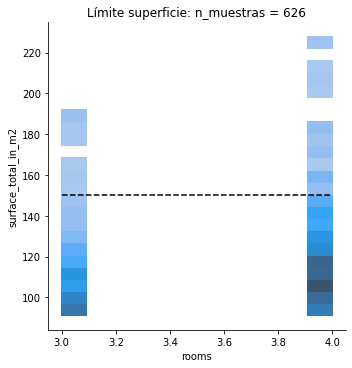

In [252]:
if visualizar:
    print(" Ditribución de surface")
    sns.displot(data=data, x="rooms", y="surface_total_in_m2").set(
        title="Límite superficie: n_muestras = 626"
    )
    plt.hlines(150, 3, 4, linestyles="--", color="black")

In [253]:
data = data[data.surface_total_in_m2 <= 150]

In [254]:
data_statistic = (
    data.groupby("place_name").price.describe().sort_values(by="mean", ascending=False)
)

data_statistic[data_statistic["count"] > 5]

count           mean           std       min       25%  \
place_name                                                              
Recoleta        48.0  275927.062500  46580.273116  150000.0  243750.0   
Barrio Norte    45.0  271355.533333  43840.681041  165000.0  250000.0   
Las Cañitas      7.0  270428.571429  36045.606033  235000.0  249500.0   
Palermo         37.0  266447.966327  45928.738612  161302.0  240000.0   
Belgrano        47.0  262987.234043  43654.317068  135000.0  239500.0   
Colegiales      10.0  258481.500000  27105.157678  228000.0  238500.0   
Caballito       85.0  245289.670588  42069.650844  123000.0  220000.0   
Villa Urquiza   10.0  238840.000000  48744.007039  170000.0  215250.0   
Barracas        33.0  230241.666667  56291.065103  130000.0  180000.0   
Almagro         48.0  223186.416667  37616.030605  130000.0  196500.0   
Villa Crespo    35.0  217542.857143  42144.947961  125000.0  189500.0   
Flores          43.0  211511.604651  59602.394329  118000.0  155000.0   
San Telmo        6.0  203313.333333  26824.113530  170000.0  182160.0   
Monserrat       14.0  199942.857143  49208.656435  148000.0  168250.0   
Once            12.0  187833.333333  39161.282673  139000.0  157500.0   
Balvanera       34.0  186441.176471  44444.170751  120000.0  150000.0   
Floresta         7.0  176999.857143  32751.320586  135000.0  157500.0   
Congreso        13.0  176115.384615  21319.155946  150000.0  160000.0   

                    50%       75%            max  
place_name                                        
Recoleta       280000.0  311250.0  345000.000000  
Barrio Norte   270000.0  300000.0  349000.000000  
Las Cañitas    260000.0  280000.0  339000.000000  
Palermo        265000.0  300000.0  343773.754086  
Belgrano       269000.0  296000.0  340000.000000  
Colegiales     260059.5  268522.0  319000.000000  
Caballito      245000.0  275000.0  340000.000000  
Villa Urquiza  232500.0  264375.0  330000.000000  
Barracas       240000.0  270000.0  340000.000000  
Almagro        220000.0  250000.0  310000.000000  
Villa Crespo   210000.0  246500.0  305000.000000  
Flores         220000.0  265000.0  330000.000000  
San Telmo      206500.0  218750.0  240000.000000  
Monserrat      187500.0  198750.0  331200.000000  
Once           185000.0  208750.0  250000.000000  
Balvanera      175000.0  207000.0  335000.000000  
Floresta       172000.0  193500.0  229999.000000  
Congreso       170000.0  185000.0  220000.000000

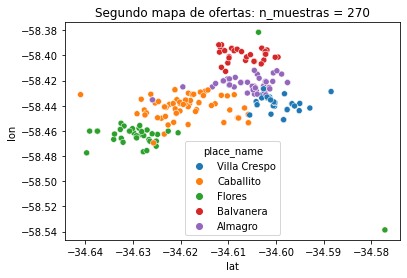

In [255]:
lista = ["Balvanera", "Flores", "Almagro", "Villa Crespo", "Caballito"]

data = data[data.place_name.isin(lista)]
if visualizar_extra:
    plt.title("Segundo mapa de ofertas: n_muestras = 270")
    sns.scatterplot(data=data, x="lat", y="lon", hue="place_name");

In [256]:
data.drop(data.lon.idxmin(), inplace=True)

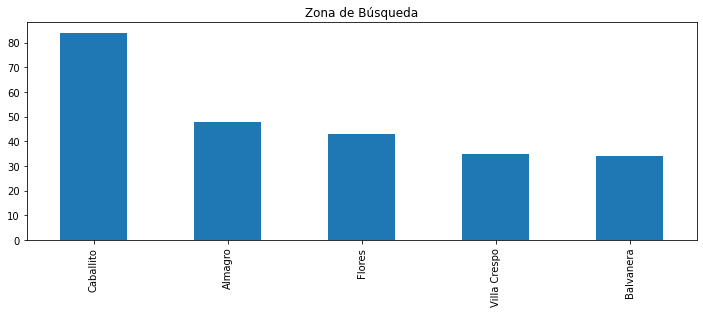

In [257]:
if visualizar:
    fig = plt.figure(figsize=(12, 4))
    data.place_name.value_counts().plot.bar()
    plt.title("Zona de Búsqueda");

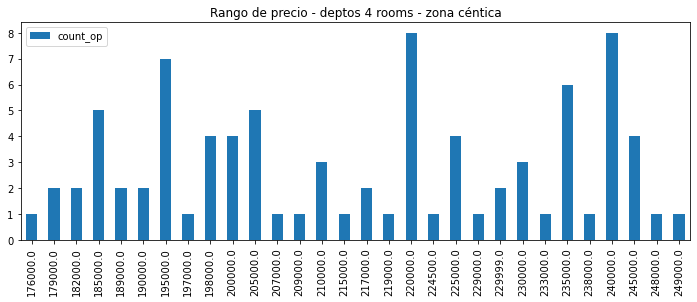

In [258]:
# print (' Ditribución de surface')
mask_1 = (data.price < 250 * 1e3) & (data.price > 175 * 1e3)
visualizar_1 = False
if visualizar_1:
    sns.displot(
        data=data, x="rooms", y="price"
    )  # .set(title='Límite superficie: n_muestras = 626')
    plt.hlines([175 * 1e3, 250 * 1e3], 3, 4, linestyles="--", color="black")


mask_2 = data.rooms == 4
visualizar_2 = False
if visualizar_2:
    sns.displot(data=data[mask_1], x="rooms", y="surface_total_in_m2")

dataview = data.loc[mask_1 & mask_2].price.value_counts()
indice_ordenado = dataview.index.sort_values()
dicc = dataview.to_dict()
dicc_ordenado = {}
for i in range(len(indice_ordenado)):
    dicc_ordenado[indice_ordenado[i]] = dicc[indice_ordenado[i]]

dataview = pd.DataFrame(dicc_ordenado.values(), index=dicc_ordenado.keys())
dataview.rename({0: "count_op"}, axis=1, inplace=True)

if visualizar:
    dataview.plot.bar(figsize=(12, 4))
    plt.title("Rango de precio - deptos 4 rooms - zona céntica");
    # plt.vlines([193*1e3, 206*1e3, 219.5*1e3, 227*1e3, 234*1e3, 247*1e3], 0, 8)#, linestyles='--', colors='black')# no func

In [259]:
bins = [
    -np.inf,
    193 * 1e3,
    206 * 1e3,
    219.5 * 1e3,
    227 * 1e3,
    234 * 1e3,
    247 * 1e3,
    np.inf,
]
# labels = ['176_a_190', '195_a_205', '207_a_219', '220_a_225', '229_a_233', '235_a_245', '248_249']
labels = [1, 2, 3, 4, 5, 6, 7]
categoria = pd.cut(data[mask_1 & mask_2].price, bins=bins, labels=labels)

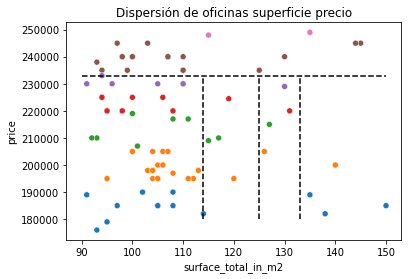

In [260]:
if visualizar:
    sns.scatterplot(
        data=data[mask_1 & mask_2],
        x="surface_total_in_m2",
        y="price",
        hue=categoria,
        legend=False,
    )
    plt.hlines(233 * 1e3, 90, 150, linestyle="--", colors="black")
    plt.vlines([133, 125, 114], 180 * 1e3, 233 * 1e3, linestyle="--", colors="black")
    plt.title("Dispersión de oficinas superficie precio");

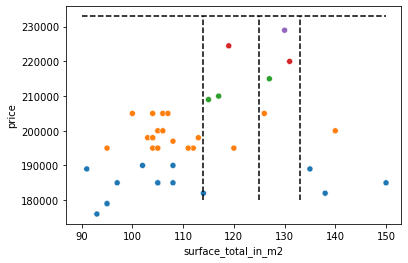

In [261]:
data = data[mask_1 & mask_2]
data["categoria_1"] = categoria
data.drop(data[data.categoria_1.isin([6, 7])].index, inplace=True)
data = data[(data.categoria_1 <= 2) | (data.surface_total_in_m2 > 114)]

if visualizar:
    sns.scatterplot(
        data=data, x="surface_total_in_m2", y="price", hue=categoria, legend=False
    )
    plt.hlines(233 * 1e3, 90, 150, linestyle="--", colors="black")
    plt.vlines([133, 125, 114], 180 * 1e3, 233 * 1e3, linestyle="--", colors="black")

In [262]:
print("Cantidad de publicaciones para oficinas:")
print()
print(pd.Series(data.state_name.value_counts()).to_string())
print()
print(pd.Series(data.place_name.value_counts()).to_string())

Cantidad de publicaciones para oficinas:

Capital Federal    41

Almagro         13
Villa Crespo    10
Flores           7
Balvanera        6
Caballito        5


In [263]:
data.drop("state_name", axis=1, inplace=True)
data = data.sort_values(by="surface_total_in_m2", ascending=False).iloc[:, :8]

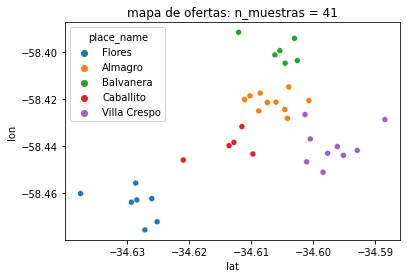

In [264]:
if visualizar:
    plt.title("mapa de ofertas: n_muestras = {}".format(data.shape[0]))
    sns.scatterplot(data=data, x="lat", y="lon", hue="place_name");

In [265]:
data = data[data.place_name != "Flores"]
lista_place_name = data.place_name.unique()

data_oficinas = data.copy()

print("Muestra de oficinas final: publicaciones = {}".format(data_oficinas.shape[0]))
data_oficinas.head()

Muestra de oficinas final: publicaciones = 34


place_name        lat        lon     price currency  \
6766     Almagro -34.608559 -58.417444  200000.0      USD   
50088  Balvanera -34.606183 -58.401180  189000.0      USD   
10854  Caballito -34.612783 -58.438410  220000.0      USD   
39869  Balvanera -34.604526 -58.404720  215000.0      USD   
13308  Balvanera -34.602563 -58.403623  195000.0      USD   

       surface_total_in_m2  surface_covered_in_m2  rooms  
6766                 140.0                  130.0    4.0  
50088                135.0                  122.0    4.0  
10854                131.0                  126.0    4.0  
39869                127.0                  116.0    4.0  
13308                120.0                  112.0    4.0

-----
### BÚSQUEDA DE DEPARTAMENTOS

-----

In [266]:
lista_place_name

array(['Almagro', 'Balvanera', 'Caballito', 'Villa Crespo'], dtype=object)

In [267]:
data = pd.DataFrame(Dicto["data"][-1])
data.drop("state_name", axis=1, inplace=True)
data = data[data.place_name.isin(lista_place_name)]
data  # n_muestra = 1729

data.etiqueta_final.value_counts()
lista_final = ["chico_medio", "chico_inferior"]
data = data[data.etiqueta_final.isin(lista_final)]
data  # n_muestra = 1352

data_info(data)
data = data.iloc[:, :9]
# data.drop('currency', axis=1, inplace=True)
data

place_name        lat        lon     price currency  \
52         Caballito -34.622211 -58.439128  110000.0      USD   
54         Caballito -34.620928 -58.445874  220410.0      USD   
55         Caballito -34.620928 -58.445874  222780.0      USD   
59         Caballito -34.628786 -58.427783  108000.0      USD   
207     Villa Crespo -34.597679 -58.443019   73800.0      USD   
...              ...        ...        ...       ...      ...   
119842     Caballito -34.620690 -58.444768  120000.0      USD   
119967     Balvanera -34.609644 -58.396493  203000.0      USD   
119968     Balvanera -34.609644 -58.396493  217000.0      USD   
119969     Balvanera -34.609644 -58.396493  149300.0      USD   
119970     Balvanera -34.609644 -58.396493  118400.0      USD   

        surface_total_in_m2  surface_covered_in_m2  rooms  categoria_final  
52                     50.0                   50.0    3.0              3.0  
54                     81.0                   75.0    3.0              3.0  
55                     81.0                   75.0    3.0              3.0  
59                     70.0                   67.0    3.0              4.0  
207                    42.0                   39.0    1.0              4.0  
...                     ...                    ...    ...              ...  
119842                 51.0                   51.0    3.0              3.0  
119967                 83.0                   72.0    3.0              3.0  
119968                 82.0                   72.0    3.0              3.0  
119969                 56.0                   49.0    2.0              3.0  
119970                 45.0                   38.0    1.0              3.0  

[1352 rows x 9 columns]

-----
**FEATURE DBSCAN**

----

In [268]:
dummys = pd.get_dummies(data.place_name, drop_first=True)
X = data.drop(["place_name", "currency"], axis=1)
X = pd.concat([X, dummys], axis=1)
X_col = X.columns
X_dex = X.index
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X, index=X_dex, columns=X_col)
X

lat       lon     price  surface_total_in_m2  \
52     -1.299669 -0.346776 -0.189120            -0.123400   
54     -1.170098 -0.711252  2.593413             1.609825   
55     -1.170098 -0.711252  2.653141             1.609825   
59     -1.963565  0.266246 -0.239524             0.994810   
207     1.177298 -0.557034 -1.101426            -0.570684   
...          ...       ...       ...                  ...   
119842 -1.146088 -0.651512  0.062898            -0.067490   
119967 -0.030820  1.956972  2.154649             1.721646   
119968 -0.030820  1.956972  2.507475             1.665736   
119969 -0.030820  1.956972  0.801312             0.212063   
119970 -0.030820  1.956972  0.022575            -0.402953   

        surface_covered_in_m2     rooms  categoria_final  Balvanera  \
52                   0.157929  0.985383        -0.484462  -0.411765   
54                   1.728395  0.985383        -0.484462  -0.411765   
55                   1.728395  0.985383        -0.484462  -0.411765   
59                   1.225846  0.985383         2.064146  -0.411765   
207                 -0.533076 -1.159927         2.064146  -0.411765   
...                       ...       ...              ...        ...   
119842               0.220748  0.985383        -0.484462  -0.411765   
119967               1.539939  0.985383        -0.484462   2.428571   
119968               1.539939  0.985383        -0.484462   2.428571   
119969               0.095111 -0.087272        -0.484462   2.428571   
119970              -0.595894 -1.159927        -0.484462   2.428571   

        Caballito  Villa Crespo  
52       1.260967     -0.521414  
54       1.260967     -0.521414  
55       1.260967     -0.521414  
59       1.260967     -0.521414  
207     -0.793042      1.917864  
...           ...           ...  
119842   1.260967     -0.521414  
119967  -0.793042     -0.521414  
119968  -0.793042     -0.521414  
119969  -0.793042     -0.521414  
119970  -0.793042     -0.521414  

[1352 rows x 10 columns]

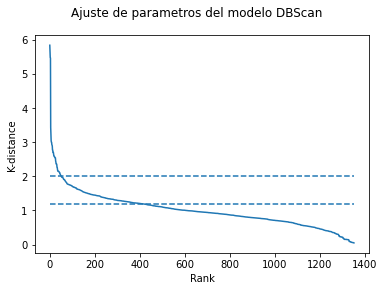

In [269]:
# CREACION MODELO DBSCAN
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.6, min_samples=15)

# AJUSTE DE PARAMETROS
from scipy.spatial.distance import pdist, squareform

minPts = 15
# 2D
k = minPts - 1
D = squareform(pdist(X))
k_distances = np.zeros(D.shape[0])

for i in range(D.shape[0]):
    distances = np.sort(D[i])
    k_distances[i] = distances[k]

k_distances = np.sort(k_distances)
k_distances = k_distances[::-1]


if visualizar:
    plt.suptitle("Ajuste de parametros del modelo DBScan")
    plt.plot(k_distances)
    plt.xlabel("Rank")
    plt.ylabel("K-distance")
    plt.hlines([1.2, 2], 0, D.shape[0], linestyles="dashed");

In [270]:
y_pred = dbscan.fit_predict(X)
print("# cantidad de categorias")

print(pd.Series(pd.Series((dbscan.labels_)).unique()).count())
print("# cantidad de outliers")
print((y_pred == -1).sum())

data["categoria_dbscan"] = y_pred

data[data.categoria_dbscan == -1].shape[0]
data.drop(data[data.categoria_dbscan == -1].index, inplace=True)

# cantidad de categorias
9
# cantidad de outliers
36


----
**FEATURE CLUSTERING JERARQUICO**

-----

In [271]:
# Cluster Jerarquico
dummys = pd.get_dummies(data.place_name, drop_first=True)
X = data.drop(["place_name", "currency"], axis=1)
X = pd.concat([X, dummys], axis=1)
X["categoria_dbscan"] = data["categoria_dbscan"]

X_col = X.columns
X_dex = X.index
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X, index=X_dex, columns=X_col)

X.head()

lat       lon     price  surface_total_in_m2  surface_covered_in_m2  \
52  -1.304029 -0.390688 -0.197465            -0.113426               0.157553   
54  -1.172090 -0.776795  2.592463             1.626826               1.728311   
55  -1.172090 -0.776795  2.652351             1.626826               1.728311   
59  -1.980063  0.258716 -0.248003             1.009317               1.225669   
218  1.218218 -0.613424 -1.410368            -1.067758              -1.036223   

        rooms  categoria_final  categoria_dbscan  Balvanera  Caballito  \
52   0.978725        -0.460203         -0.927840  -0.415819   1.265224   
54   0.978725        -0.460203         -0.927840  -0.415819   1.265224   
55   0.978725        -0.460203         -0.927840  -0.415819   1.265224   
59   0.978725         2.172956          2.748401  -0.415819   1.265224   
218 -1.164373        -0.460203         -0.402662  -0.415819  -0.790374   

     Villa Crespo  
52      -0.511610  
54      -0.511610  
55      -0.511610  
59      -0.511610  
218      1.954613

In [272]:
lista_modos = ["ward", "average", "complete", "single"]

for elemento in lista_modos:
    Z = linkage(X, elemento)
    c, dist = cophenet(Z, pdist(X))
    print('coeficiente Cophenetic: "{}"" = {}'.format(elemento, "%.2f" % c))

coeficiente Cophenetic: "ward"" = 0.73
coeficiente Cophenetic: "average"" = 0.79
coeficiente Cophenetic: "complete"" = 0.67
coeficiente Cophenetic: "single"" = 0.74


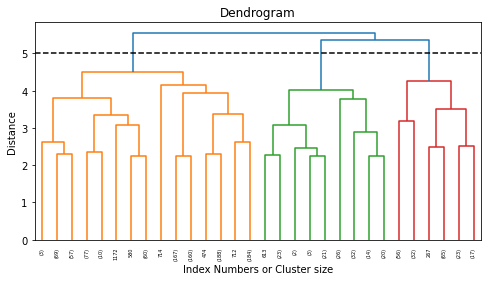

In [273]:
Z = linkage(X, "average")

plt.figure(figsize=[8, 4])
plt.title("Dendrogram")
plt.xlabel("Index Numbers or Cluster size")
plt.ylabel("Distance")

ax = plt.axes()

dendrogram(
    Z,
    leaf_rotation=90.0,
    leaf_font_size=5.0,
    color_threshold=5,
    truncate_mode="lastp",
    ax=ax,
)

plt.hlines(5, 0, X.shape[0] * 100, linestyle="--", colors="black")
plt.show()

In [274]:
labels = fcluster(Z, 3, criterion="maxclust")
data.loc[:, "categoria_jerarquica"] = labels
data.head()

place_name        lat        lon     price currency  \
52      Caballito -34.622211 -58.439128  110000.0      USD   
54      Caballito -34.620928 -58.445874  220410.0      USD   
55      Caballito -34.620928 -58.445874  222780.0      USD   
59      Caballito -34.628786 -58.427783  108000.0      USD   
218  Villa Crespo -34.597679 -58.443019   62000.0      USD   

     surface_total_in_m2  surface_covered_in_m2  rooms  categoria_final  \
52                  50.0                   50.0    3.0              3.0   
54                  81.0                   75.0    3.0              3.0   
55                  81.0                   75.0    3.0              3.0   
59                  70.0                   67.0    3.0              4.0   
218                 33.0                   31.0    1.0              3.0   

     categoria_dbscan  categoria_jerarquica  
52                  0                     1  
54                  0                     1  
55                  0                     1  
59                  7                     2  
218                 1                     1

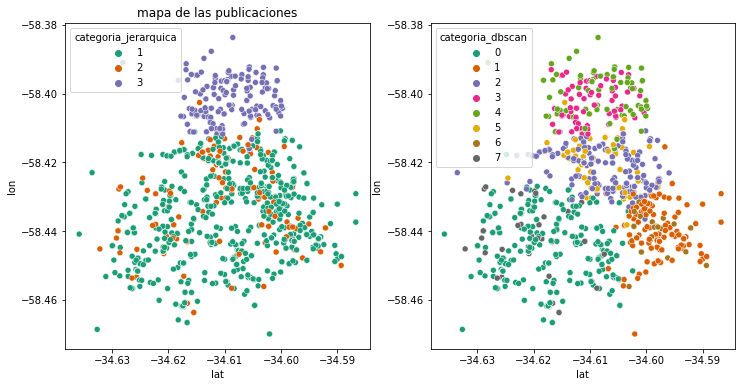

In [275]:
if visualizar_extra:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(
        data=data,
        x="lat",
        y="lon",
        hue="categoria_jerarquica",
        palette="Dark2",
        ax=ax[0],
    ).set(title="mapa de las publicaciones")
    sns.scatterplot(
        data=data, x="lat", y="lon", hue="categoria_dbscan", palette="Dark2", ax=ax[1]
    )

In [276]:
data.groupby("categoria_jerarquica").price.describe()

count           mean           std      min       25%  \
categoria_jerarquica                                                          
1                     980.0  117634.583098  40336.510938  35000.0   85000.0   
2                     142.0  132916.304768  31446.439756  59000.0  108000.0   
3                     194.0  107670.103093  37840.715153  45000.0   78000.0   

                           50%        75%       max  
categoria_jerarquica                                 
1                     112000.0  141999.25  245000.0  
2                     135000.0  156875.00  190000.0  
3                     109000.0  135000.00  220000.0

In [277]:
grupo = (
    data.groupby("categoria_dbscan")
    .price.describe()
    .iloc[:, :]
    .sort_values(by="mean", ascending=False)
)
grupo["CV"] = grupo["std"] / grupo["mean"]
grupo

count           mean           std       min       25%  \
categoria_dbscan                                                           
6                  26.0  152889.779887  16308.079528  115000.0  150500.0   
7                  50.0  130056.760000  32422.182723   74000.0  102000.0   
5                  66.0  127214.287879  32426.770444   59000.0  105000.0   
0                 456.0  126086.061233  42334.735506   53000.0   94350.0   
3                  88.0  113745.454545  29137.217615   55000.0   94250.0   
2                 277.0  111209.636088  39141.334072   43000.0   79618.0   
1                 247.0  109237.159180  34519.616420   35000.0   85000.0   
4                 106.0  102626.415094  43266.052461   45000.0   68675.0   

                       50%       75%       max        CV  
categoria_dbscan                                          
6                 155000.0  160000.0  180000.0  0.106666  
7                 131000.0  155000.0  187846.0  0.249293  
5                 126000.0  150000.0  190000.0  0.254899  
0                 118000.0  149947.5  245000.0  0.335761  
3                 117000.0  135750.0  175000.0  0.256162  
2                  98000.0  143000.0  219000.0  0.351960  
1                  98000.0  128500.0  210580.0  0.316006  
4                  89500.0  133750.0  220000.0  0.421588

In [278]:
data_depto = data[
    data.categoria_dbscan.isin([2, 5])
    & (data.categoria_jerarquica == 1)
    & (data.price < 142 * 1e3)
]
data_depto.place_name.value_counts()
data_depto.rooms.value_counts()

1.0    114
2.0     69
3.0     22
4.0      1
Name: rooms, dtype: int64

In [279]:
data_depto = data_depto.iloc[:, :8]
data_depto["categoria_result"] = "departamento"
data_depto.head()

place_name        lat        lon     price currency  surface_total_in_m2  \
405     Almagro -34.617691 -58.422826  120000.0      USD                 56.0   
656     Almagro -34.597812 -58.425597   78490.0      USD                 38.0   
1391    Almagro -34.611058 -58.420189   73038.0      USD                 38.0   
1471    Almagro -34.600011 -58.427424   81200.0      USD                 35.0   
5451    Almagro -34.603077 -58.428593   80000.0      USD                 42.0   

      surface_covered_in_m2  rooms categoria_result  
405                    47.0    3.0     departamento  
656                    32.0    1.0     departamento  
1391                   34.0    1.0     departamento  
1471                   32.0    1.0     departamento  
5451                   40.0    2.0     departamento

-----------
### CREAMOS EL DATASET DE RESULTADO

-----------

FINALMENTE DECIDIMOS AJUSTAR LAS OPCIONES A LA ZONA DE **ALMAGRO**

In [280]:
data_oficinas["categoria_result"] = "oficina"
mask_almagro = data_oficinas.place_name == "Almagro"

In [281]:
data_result = pd.concat([data_depto, data_oficinas[mask_almagro]])
data_result.sample(5)

place_name        lat        lon     price currency  surface_total_in_m2  \
405     Almagro -34.617691 -58.422826  120000.0      USD                 56.0   
656     Almagro -34.597812 -58.425597   78490.0      USD                 38.0   
1391    Almagro -34.611058 -58.420189   73038.0      USD                 38.0   
1471    Almagro -34.600011 -58.427424   81200.0      USD                 35.0   
5451    Almagro -34.603077 -58.428593   80000.0      USD                 42.0   

      surface_covered_in_m2  rooms categoria_result  
405                    47.0    3.0     departamento  
656                    32.0    1.0     departamento  
1391                   34.0    1.0     departamento  
1471                   32.0    1.0     departamento  
5451                   40.0    2.0     departamento

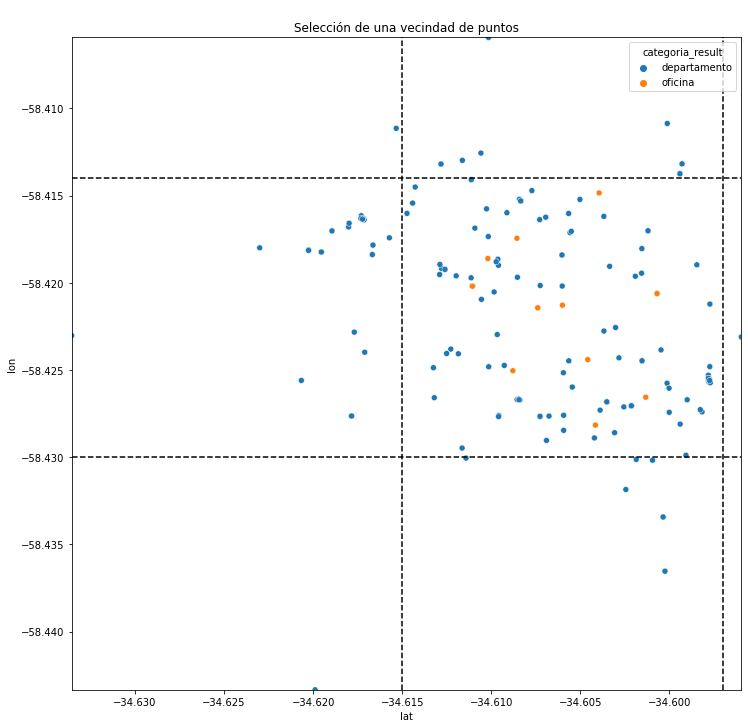

In [282]:
x1_y1 = [data_result.lat.min(), -58.414]
x2_y2 = [data_result.lat.max(), -58.430]

x3_y3 = [-34.615, data_result.lon.min()]
x4_y4 = [-34.597, data_result.lon.max()]

if visualizar:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set(xlim=(x1_y1[0], x2_y2[0]), ylim=(x3_y3[1], x4_y4[1]))

    sns.scatterplot(data=data_result, x="lat", y="lon", hue="categoria_result")

    plt.hlines(
        [x1_y1[1], x2_y2[1]], x1_y1[0], x2_y2[0], linestyles="--", colors="black"
    )

    plt.vlines(
        [x3_y3[0], x4_y4[0]], x3_y3[1], x4_y4[1], linestyles="--", colors="black"
    )

    plt.title("\nSelección de una vecindad de puntos");

In [283]:
"""(lon > -58.43 and lon < -58.414) 
    and (lat > -34.615 and lat < -34.597)
"""
# data_result[data_result.eval('(lat > -34.615 and lat < -34.597)')]
data_result = data_result[
    data_result.eval(
        "(lon > -58.43 and lon < -58.414) and (lat > -34.615 and lat < -34.597)"
    )
]
data_result.head()

place_name        lat        lon     price currency  surface_total_in_m2  \
656     Almagro -34.597812 -58.425597   78490.0      USD                 38.0   
1391    Almagro -34.611058 -58.420189   73038.0      USD                 38.0   
1471    Almagro -34.600011 -58.427424   81200.0      USD                 35.0   
5451    Almagro -34.603077 -58.428593   80000.0      USD                 42.0   
6105    Almagro -34.612600 -58.419229  100000.0      USD                 35.0   

      surface_covered_in_m2  rooms categoria_result  
656                    32.0    1.0     departamento  
1391                   34.0    1.0     departamento  
1471                   32.0    1.0     departamento  
5451                   40.0    2.0     departamento  
6105                   29.0    1.0     departamento

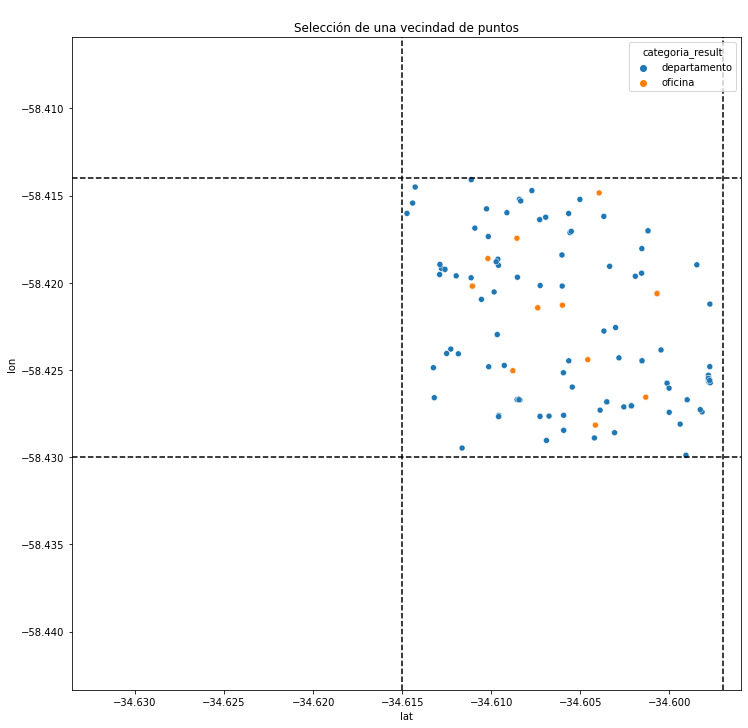

In [284]:
if visualizar:
    fig, ax = plt.subplots(figsize=(12, 12))

    ax.set(xlim=(x1_y1[0], x2_y2[0]), ylim=(x3_y3[1], x4_y4[1]))

    sns.scatterplot(data=data_result, x="lat", y="lon", hue="categoria_result")
    plt.hlines(
        [x1_y1[1], x2_y2[1]], x1_y1[0], x2_y2[0], linestyles="--", colors="black"
    )

    plt.vlines(
        [x3_y3[0], x4_y4[0]], x3_y3[1], x4_y4[1], linestyles="--", colors="black"
    )

    plt.title("\nSelección de una vecindad de puntos");

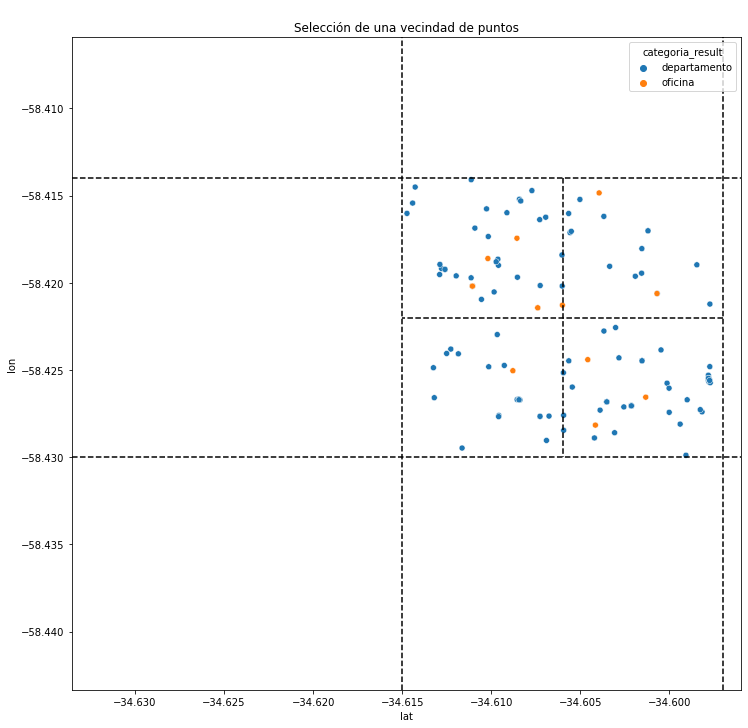

In [285]:
# es esta distancia, mas la distancia menos esta distancia, dividido 2
a = (x3_y3[0] - x4_y4[0]) / 2
b = (x1_y1[1] - x2_y2[1]) / 2

med_sup = [x4_y4[0] + a, x1_y1[1]]
med_inf = [x4_y4[0] + a, x2_y2[1]]

med_izq = [x3_y3[0], x2_y2[1] + b]
med_dcha = [x4_y4[0], x2_y2[1] + b]

if visualizar:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set(xlim=(x1_y1[0], x2_y2[0]), ylim=(x3_y3[1], x4_y4[1]))
    sns.scatterplot(data=data_result, x="lat", y="lon", hue="categoria_result")

    plt.hlines(
        [x1_y1[1], x2_y2[1]], x1_y1[0], x2_y2[0], linestyles="--", colors="black"
    )
    plt.vlines(
        [x3_y3[0], x4_y4[0]], x3_y3[1], x4_y4[1], linestyles="--", colors="black"
    )

    plt.hlines(med_dcha[1], med_dcha[0], med_izq[0], linestyles="--", colors="black")
    plt.vlines(med_sup[0], med_sup[1], med_inf[1], linestyles="--", colors="black")

    plt.title("\nSelección de una vecindad de puntos");

In [286]:
"""
med_sup = [x4_y4[0]+a, x1_y1[1]]
med_inf = [x4_y4[0]+a, x2_y2[1]]

med_izq = [x3_y3[0], x2_y2[1]+b]
med_dcha = [x4_y4[0], x2_y2[1]+b]
"""

mask_dcha = (data_result.lat > med_inf[0]) & (data_result.lat < med_dcha[0])

mask_sup = (data_result.lon > med_izq[1]) & (data_result.lon < med_sup[1])

data_result.loc[mask_dcha & mask_sup, "primer_cuadrante"] = 1
data_result.loc[~mask_dcha & mask_sup, "segundo_cuadrante"] = 1
data_result.loc[~mask_dcha & ~mask_sup, "tercer_cuadrante"] = 1
data_result.loc[mask_dcha & ~mask_sup, "cuarto_cuadrante"] = 1
data_result.fillna(0, inplace=True)

In [287]:
data_result.groupby("categoria_result")[list(data_result.columns)[-4:]].sum()

primer_cuadrante  segundo_cuadrante  tercer_cuadrante  \
categoria_result                                                          
departamento                  14.0               60.0              19.0   
oficina                        2.0                7.0               1.0   

                  cuarto_cuadrante  
categoria_result                    
departamento                  67.0  
oficina                        3.0

In [288]:
display(data_result.head())

place_name        lat        lon     price currency  surface_total_in_m2  \
656     Almagro -34.597812 -58.425597   78490.0      USD                 38.0   
1391    Almagro -34.611058 -58.420189   73038.0      USD                 38.0   
1471    Almagro -34.600011 -58.427424   81200.0      USD                 35.0   
5451    Almagro -34.603077 -58.428593   80000.0      USD                 42.0   
6105    Almagro -34.612600 -58.419229  100000.0      USD                 35.0   

      surface_covered_in_m2  rooms categoria_result  primer_cuadrante  \
656                    32.0    1.0     departamento               0.0   
1391                   34.0    1.0     departamento               0.0   
1471                   32.0    1.0     departamento               0.0   
5451                   40.0    2.0     departamento               0.0   
6105                   29.0    1.0     departamento               0.0   

      segundo_cuadrante  tercer_cuadrante  cuarto_cuadrante  
656                 0.0               0.0               1.0  
1391                1.0               0.0               0.0  
1471                0.0               0.0               1.0  
5451                0.0               0.0               1.0  
6105                1.0               0.0               0.0

-----

# 6) <u>PROXIMAS ACTUALIZACIONES

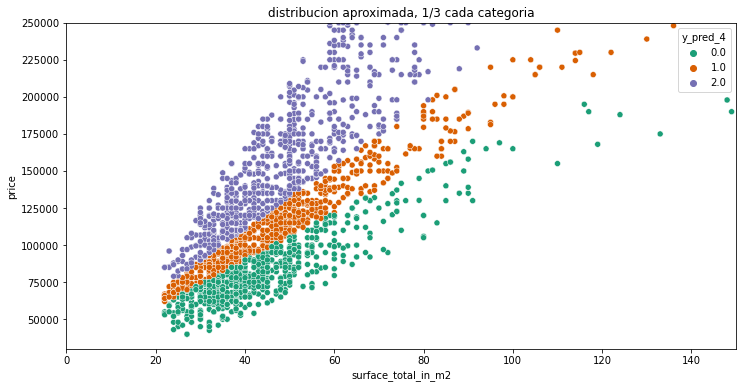

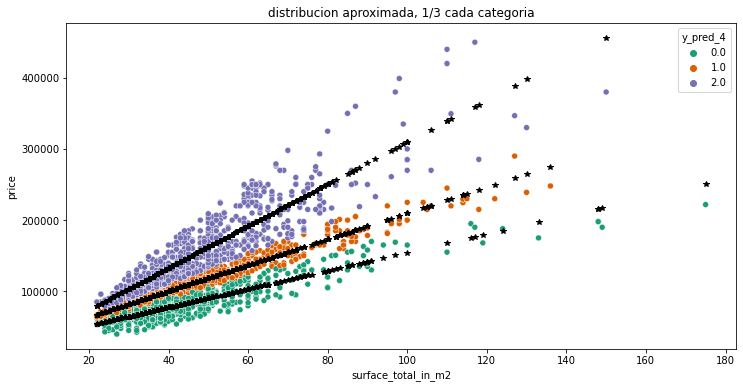

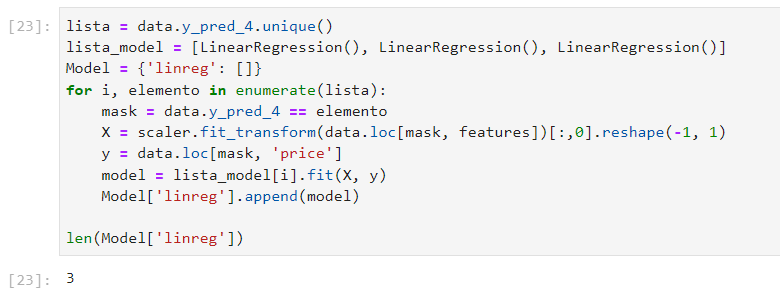